In [3]:
import torch
import torch.nn as nn
import os
import wandb
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from IPython.display import clear_output, display, HTML
import time

# Initialize wandb - will use WANDB_API_KEY environment variable if available
try:
    # Fix wandb login - only call once
    wandb.login(key="999fe4f321204bd8f10135f3e40de296c23050f9")
except:
    print("WandB login failed - results will not be logged. Set WANDB_API_KEY in your environment.")

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, bidirectional=False):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)

        self.directions = 2 if bidirectional else 1

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True,
                              dropout=dropout if num_layers > 1 else 0,
                              bidirectional=bidirectional)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers, batch_first=True,
                             dropout=dropout if num_layers > 1 else 0,
                             bidirectional=bidirectional)
        else:  # rnn
            self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers, batch_first=True,
                             dropout=dropout if num_layers > 1 else 0,
                             bidirectional=bidirectional)

        # Projection layer to reduce bidirectional output to the expected dimension
        if bidirectional:
            self.projection = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))

        if self.rnn_type == 'lstm':
            outputs, (hidden, cell) = self.rnn(embedded)

            # Process bidirectional states if needed
            if self.bidirectional:
                # Process hidden states
                hidden = hidden.view(self.num_layers, self.directions, -1, self.hidden_dim)
                # Concat forward and backward directions
                hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
                # Project to the correct dimension
                hidden = self.projection(hidden)

                # Process cell states
                cell = cell.view(self.num_layers, self.directions, -1, self.hidden_dim)
                cell = torch.cat([cell[:, 0], cell[:, 1]], dim=2)
                cell = self.projection(cell)

                # If outputs is bidirectional, we need to process it too
                batch_size = outputs.size(0)
                seq_len = outputs.size(1)
                # Reshape and project encoder outputs
                outputs = outputs.contiguous().view(batch_size, seq_len, self.hidden_dim * 2)
                outputs = self.projection(outputs)

                return outputs, (hidden, cell)
            return outputs, (hidden, cell)
        else:
            outputs, hidden = self.rnn(embedded)

            # Process bidirectional states if needed
            if self.bidirectional:
                hidden = hidden.view(self.num_layers, self.directions, -1, self.hidden_dim)
                hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
                hidden = self.projection(hidden)

                # Process outputs if bidirectional
                batch_size = outputs.size(0)
                seq_len = outputs.size(1)
                # Reshape and project encoder outputs
                outputs = outputs.contiguous().view(batch_size, seq_len, self.hidden_dim * 2)
                outputs = self.projection(outputs)

            return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, attention=False):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = nn.Dropout(dropout)
        self.attention = attention

        # Increase input size if using attention
        rnn_input_size = emb_dim + hidden_dim if attention else emb_dim

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(rnn_input_size, hidden_dim, num_layers, batch_first=True,
                              dropout=dropout if num_layers > 1 else 0)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(rnn_input_size, hidden_dim, num_layers, batch_first=True,
                             dropout=dropout if num_layers > 1 else 0)
        else:  # rnn
            self.rnn = nn.RNN(rnn_input_size, hidden_dim, num_layers, batch_first=True,
                             dropout=dropout if num_layers > 1 else 0)

        # Attention mechanism
        if attention:
            # Attention layers - simplified approach that works with any encoder output dimensionality
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_char, hidden, encoder_outputs=None):
        input_char = input_char.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input_char))  # [batch_size, 1, emb_dim]

        # Apply attention if enabled and encoder_outputs are provided
        if self.attention and encoder_outputs is not None:
            # Make sure we're extracting the hidden state correctly based on RNN type
            if self.rnn_type == 'lstm':
                query = hidden[0][-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
            else:
                query = hidden[-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]

            # Get dimensions
            batch_size = encoder_outputs.size(0)
            src_len = encoder_outputs.size(1)

            # Create energy by combining query with encoder outputs
            query = query.repeat(1, src_len, 1)  # [batch_size, src_len, hidden_dim]

            # Concatenate query with encoder outputs
            energy_input = torch.cat((query, encoder_outputs), dim=2)  # [batch_size, src_len, 2*hidden_dim]

            # Calculate attention scores
            energy = torch.tanh(self.attn(energy_input))  # [batch_size, src_len, hidden_dim]
            attention = self.v(energy).squeeze(2)  # [batch_size, src_len]

            # Apply softmax to get attention weights
            attention_weights = torch.softmax(attention, dim=1).unsqueeze(1)  # [batch_size, 1, src_len]

            # Create context vector by applying attention weights to encoder outputs
            context = torch.bmm(attention_weights, encoder_outputs)  # [batch_size, 1, hidden_dim]

            # Combine with embedding
            rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, emb_dim+hidden_dim]
        else:
            rnn_input = embedded

        # Forward pass through RNN
        if self.rnn_type == 'lstm':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
            hidden_state = (hidden, cell)
        else:
            output, hidden = self.rnn(rnn_input, hidden)
            hidden_state = hidden

        # Generate prediction
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]

        # Return attention_weights if available
        if self.attention and encoder_outputs is not None:
            return prediction, hidden_state, attention_weights.squeeze(1)  # [batch_size, src_len]
        else:
            return prediction, hidden_state, None


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, rnn_type, device, use_attention=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rnn_type = rnn_type
        self.device = device
        self.use_attention = use_attention

    def forward(self, src, trg, teacher_forcing_ratio=0.0):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # For collecting attention weights
        all_attention_weights = [] if self.use_attention else None

        # Encode the source sequence
        encoder_outputs, hidden = self._encode(src)

        # Use the first token as input to start decoding
        input_char = trg[:, 0]  # <sos> token

        

        for t in range(1, trg_len):
            # Generate output from decoder
            if self.use_attention:
                output, hidden, attn_weights  = self.decoder(input_char, hidden, encoder_outputs)
                all_attention_weights.append(attn_weights)  # <-- ADD THIS LINE
            else:
                output, hidden, attn = self.decoder(input_char, hidden)

            outputs[:, t] = output

            # Teacher forcing: use real target or predicted token
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_char = trg[:, t] if teacher_force else top1

        return outputs, all_attention_weights 

    def _encode(self, src):
        # Get encoder outputs and final hidden state
        encoder_outputs, hidden = self.encoder(src)

        # Adjust hidden state dimensions if encoder and decoder have different layers
        encoder_layers = self.encoder.num_layers
        decoder_layers = self.decoder.num_layers

        if self.rnn_type == 'lstm':
            hidden_state, cell_state = hidden

            # If encoder has fewer layers than decoder, pad with zeros
            if encoder_layers < decoder_layers:
                padding = torch.zeros(
                    decoder_layers - encoder_layers,
                    hidden_state.size(1),
                    hidden_state.size(2)
                ).to(self.device)
                hidden_state = torch.cat([hidden_state, padding], dim=0)
                cell_state = torch.cat([cell_state, padding], dim=0)

            # If encoder has more layers than decoder, truncate
            elif encoder_layers > decoder_layers:
                hidden_state = hidden_state[:decoder_layers]
                cell_state = cell_state[:decoder_layers]

            # Make sure hidden dimensions match decoder's expected dimensions
            if hidden_state.size(2) != self.decoder.hidden_dim:
                # Project hidden state to the decoder's dimension using a linear projection
                batch_size = hidden_state.size(1)
                proj_hidden = torch.zeros(
                    hidden_state.size(0),
                    batch_size,
                    self.decoder.hidden_dim
                ).to(self.device)

                for layer in range(hidden_state.size(0)):
                    # Simple linear projection for each layer
                    proj_hidden[layer] = hidden_state[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]

                # Apply the same projection to cell state
                proj_cell = torch.zeros_like(proj_hidden)
                for layer in range(cell_state.size(0)):
                    proj_cell[layer] = cell_state[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]

                hidden = (proj_hidden, proj_cell)
            else:
                hidden = (hidden_state, cell_state)
        else:
            # For GRU and RNN
            # If encoder has fewer layers than decoder, pad with zeros
            if encoder_layers < decoder_layers:
                padding = torch.zeros(
                    decoder_layers - encoder_layers,
                    hidden.size(1),
                    hidden.size(2)
                ).to(self.device)
                hidden = torch.cat([hidden, padding], dim=0)
            # If encoder has more layers than decoder, truncate
            elif encoder_layers > decoder_layers:
                hidden = hidden[:decoder_layers]

            # Make sure hidden dimensions match decoder's expected dimensions
            if hidden.size(2) != self.decoder.hidden_dim:
                # Project hidden state to the decoder's dimension
                batch_size = hidden.size(1)
                proj_hidden = torch.zeros(
                    hidden.size(0),
                    batch_size,
                    self.decoder.hidden_dim
                ).to(self.device)

                for layer in range(hidden.size(0)):
                    # Simple linear projection for each layer
                    proj_hidden[layer] = hidden[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]

                hidden = proj_hidden

        return encoder_outputs, hidden

        def predict(self, src):
            """Generate predictions from the model for evaluation"""
            batch_size = src.size(0)
            max_len = 100  # Maximum prediction length
            
            # Create tensor to store predictions
            predictions = torch.zeros(batch_size, max_len, dtype=torch.long).to(self.device)
            
            # Encode the source sequence
            encoder_outputs, hidden = self._encode(src)
            
            # Initialize with start token
            input_char = torch.tensor([1] * batch_size).to(self.device)  # <sos> token
            
            for t in range(max_len):
                # Generate output from decoder
                if self.use_attention:
                    output, hidden, _ = self.decoder(input_char, hidden, encoder_outputs)
                else:
                    output, hidden, _ = self.decoder(input_char, hidden)
                    
                # Get the most likely next token
                predictions[:, t] = output.argmax(1)
                
                # Update input for next step
                input_char = predictions[:, t]
                
                # Stop if all sequences have predicted <eos>
                if (input_char == 2).all():  # All sequences generated <eos>
                    break
                    
            return predictions


# Character-level vocabulary builder
def build_vocab(tokens):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    for token in tokens:
        for char in token:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

def encode_sequence(seq, vocab):
    return [vocab.get(char, vocab['<unk>']) for char in seq]

class DakshinaDataset(Dataset):
    def __init__(self, data_path, latin_vocab=None, devanagari_vocab=None):
        self.latin_words = []
        self.devanagari_words = []

        # Group all transliterations by Devanagari word
        candidates = defaultdict(list)

        with open(data_path, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 3:
                    continue
                native, latin, rel = parts[0], parts[1], int(parts[2])
                candidates[native].append((latin, rel))

        # Keep only the transliteration(s) with highest score for each native word
        for native, translits in candidates.items():
            max_rel = max(rel for _, rel in translits)
            for latin, rel in translits:
                if rel == max_rel:
                    self.latin_words.append(latin)
                    self.devanagari_words.append(native)

        print(f"Dataset from {data_path}: {len(self.latin_words)} pairs.")

        self.latin_vocab = latin_vocab or build_vocab(self.latin_words)
        self.devanagari_vocab = devanagari_vocab or build_vocab(self.devanagari_words)

    def __len__(self):
        return len(self.latin_words)

    def __getitem__(self, idx):
        src_seq = encode_sequence(self.latin_words[idx], self.latin_vocab)
        trg_seq = encode_sequence(self.devanagari_words[idx], self.devanagari_vocab)
        # add <sos> and <eos> tokens for target sequences
        trg_seq = [self.devanagari_vocab['<sos>']] + trg_seq + [self.devanagari_vocab['<eos>']]
        return src_seq, trg_seq

def collate_fn(batch):
    # batch is a list of tuples (src_seq, trg_seq)
    src_seqs, trg_seqs = zip(*batch)

    # find max lengths
    max_src_len = max(len(seq) for seq in src_seqs)
    max_trg_len = max(len(seq) for seq in trg_seqs)

    # pad sequences
    src_padded = [seq + [0]*(max_src_len - len(seq)) for seq in src_seqs]
    trg_padded = [seq + [0]*(max_trg_len - len(seq)) for seq in trg_seqs]

    # convert to tensors
    src_tensor = torch.tensor(src_padded, dtype=torch.long)
    trg_tensor = torch.tensor(trg_padded, dtype=torch.long)

    return src_tensor, trg_tensor

def compute_word_accuracy(preds, trg, pad_idx, sos_idx=1, eos_idx=2):
    """
    Compute word-level accuracy: a word is correct only if all tokens match (excluding pad, sos, eos).
    preds, trg: [batch_size, seq_len]
    """
    batch_size = preds.size(0)
    correct = 0

    for i in range(batch_size):
        # Get sequence for this example (exclude pad, sos, eos tokens)
        pred_seq = [idx for idx in preds[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
        trg_seq = [idx for idx in trg[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]

        # Compare full sequences (exact match)
        if pred_seq == trg_seq:
            correct += 1

    return correct, batch_size

def beam_search(model, src_seq, src_vocab, tgt_vocab, beam_width=3, max_len=20):
    model.eval()
    index_to_char = {v: k for k, v in tgt_vocab.items()}
    device = model.device

    # Prepare input
    src_indices = encode_sequence(src_seq, src_vocab)
    src_tensor = torch.tensor([src_indices], dtype=torch.long).to(device)

    # Get encoder outputs and hidden state
    encoder_outputs, hidden = model._encode(src_tensor)

    # Start with start-of-sequence token
    beams = [([tgt_vocab['<sos>']], 0.0, hidden)]

    for _ in range(max_len):
        new_beams = []
        for seq, score, hidden in beams:
            last_token = torch.tensor([seq[-1]], dtype=torch.long).to(device)

            # Use attention if model has it
            if model.use_attention:
                output, new_hidden, _ = model.decoder(last_token, hidden, encoder_outputs)
            else:
                output, new_hidden = model.decoder(last_token, hidden)

            log_probs = torch.log_softmax(output, dim=-1)
            topk = torch.topk(log_probs, beam_width)

            for prob, idx in zip(topk.values[0], topk.indices[0]):
                new_seq = seq + [idx.item()]
                new_score = score + prob.item()
                new_beams.append((new_seq, new_score, new_hidden))

        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        # Stop if all beams end with EOS
        if all(seq[-1] == tgt_vocab['<eos>'] for seq, _, _ in beams):
            break

    # Pick the best beam
    best_seq = beams[0][0]
    # Remove special tokens for output
    decoded = [index_to_char[i] for i in best_seq if i not in {tgt_vocab['<sos>'], tgt_vocab['<eos>'], tgt_vocab['<pad>']}]
    return ''.join(decoded)

def train(model, dataloader, optimizer, criterion, clip=1, teacher_forcing_ratio=0.0):
    model.train()
    epoch_loss = 0
    total_words = 0
    correct_words = 0

    pad_idx = 0  # Pad index in vocabulary
    sos_idx = 1  # Start of sequence index
    eos_idx = 2  # End of sequence index

    for src, trg in dataloader:
        src, trg = src.to(model.device), trg.to(model.device)
        optimizer.zero_grad()

        # Generate sequence
        output, _ = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)
        output_dim = output.shape[-1]

        # Ignore first token (<sos>) in loss calculation
        output = output[:, 1:].contiguous().view(-1, output_dim)
        trg_flat = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg_flat)
        loss.backward()

        # Use gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate word accuracy
        pred_tokens = output.argmax(1).view(trg[:, 1:].shape)  # [batch_size, trg_len-1]
        trg_trimmed = trg[:, 1:]                             # [batch_size, trg_len-1]

        correct, total = compute_word_accuracy(pred_tokens, trg_trimmed, pad_idx, sos_idx, eos_idx)
        correct_words += correct
        total_words += total

    avg_loss = epoch_loss / len(dataloader)
    word_acc = correct_words / total_words if total_words > 0 else 0

    return avg_loss, word_acc * 100

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    total_words = 0
    correct_words = 0

    pad_idx = 0  # Pad index in vocabulary
    sos_idx = 1  # Start of sequence index
    eos_idx = 2  # End of sequence index

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)

            # Generate full sequence with no teacher forcing
            output, _  = model(src, trg, teacher_forcing_ratio=0.0)
            # Visualize for the first example in batch
            # attn = torch.stack([aw[0] for aw in attention_weights]).cpu().numpy()
            output_dim = output.shape[-1]

            # Ignore first token (<sos>) in loss calculation
            output = output[:, 1:].contiguous().view(-1, output_dim)
            trg_flat = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg_flat)
            epoch_loss += loss.item()

            # Calculate word accuracy
            pred_tokens = output.argmax(1).view(trg[:, 1:].shape)
            trg_trimmed = trg[:, 1:]

            correct, total = compute_word_accuracy(pred_tokens, trg_trimmed, pad_idx, sos_idx, eos_idx)
            correct_words += correct
            total_words += total

    avg_loss = epoch_loss / len(dataloader)
    word_acc = correct_words / total_words if total_words > 0 else 0

    return avg_loss, word_acc * 100

def predict_examples(model, dataloader, latin_index_to_token, devanagari_index_to_token, n=5):
    """Show a few examples of model predictions vs actual targets"""
    model.eval()
    pad_idx = 0
    sos_idx = 1  # Start of sequence
    eos_idx = 2  # End of sequence
    count = 0
    results = []

    print("\nPrediction Examples:")
    print("-" * 60)

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)
            output, _ = model(src, trg, teacher_forcing_ratio=0.0)
            # print(len(output))
            pred_tokens = output.argmax(-1)  # [batch_size, seq_len]

            for i in range(min(src.size(0), n - count)):
                # Decode input
                input_indices = [idx for idx in src[i].tolist() if idx != pad_idx]
                input_tokens = [latin_index_to_token.get(idx, '<unk>') for idx in input_indices]
                input_text = "".join(input_tokens)

                # Decode target
                target_indices = [idx for idx in trg[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
                target_tokens = [devanagari_index_to_token.get(idx, '<unk>') for idx in target_indices]
                target_text = "".join(target_tokens)

                # Decode prediction
                pred_indices = [idx for idx in pred_tokens[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
                pred_tokens_text = [devanagari_index_to_token.get(idx, '<unk>') for idx in pred_indices]
                pred_text = "".join(pred_tokens_text)

                result = {
                    "input": input_text,
                    "target": target_text,
                    "prediction": pred_text,
                    "correct": pred_text == target_text
                }
                results.append(result)

                print(f"Input:     {input_text}")
                print(f"Target:    {target_text}")
                print(f"Predicted: {pred_text}")
                print("-" * 60)

                count += 1
                if count >= n:
                    break
            if count >= n:
                break

    return results
    
import matplotlib.pyplot as plt
import seaborn as sns

# Define sweep configuration with improved parameters
def get_sweep_config():
    sweep_config = {
        'method': 'random',
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'},
            'parameters': {
            'embed_dim': {'values': [128,256,384]},
            'hidden_dim': {'values': [256,384,512]},
            'rnn_type': {'values': ['lstm','gru']}, 
            'encoder_layers': {'values': [3,2]},
            'decoder_layers': {'values': [3,2]},
            'dropout': {'values': [0.2,0.3]},
            'learning_rate': {'values': [0.001,1e-4]},
            'batch_size': {'values': [128,256]},
            'epochs': {'values': [5,10]},
            'beam_size': {'values': [3,5]},
            'use_attention': {'values': [True]},
            'bidirectional': {'values': [True]},
            'teacher_forcing_ratio': {'values': [0.0, 0.3]},
            'weight_decay': {'values': [1e-5, 1e-6]}
        }
    }
    return sweep_config



# Global variables to track overall best model
overall_best_val_acc = 0
overall_best_model_path = ""
overall_best_config = None
overall_best_run_id = None



def save_test_predictions(model, test_loader, latin_vocab, devanagari_vocab, save_dir="predictions_attention"):
    """Saves all test predictions for the best model"""
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    latin_idx_to_token = {idx: tok for tok, idx in latin_vocab.items()}
    devanagari_idx_to_token = {idx: tok for tok, idx in devanagari_vocab.items()}
    pad_idx = devanagari_vocab['<pad>']
    
    with open(os.path.join(save_dir, "all_predictions.tsv"), "w") as f:
        f.write("Input\tTarget\tPrediction\tCorrect\n")
        
        correct = 0
        total = 0
        
        for src, trg in test_loader:
            src, trg = src.to(model.device), trg.to(model.device)
            outputs = model.predict(src)
            
            for i in range(src.size(0)):
                # Process input
                input_indices = [idx.item() for idx in src[i] if idx.item() != latin_vocab['<pad>']]
                input_text = ''.join([latin_idx_to_token[idx] for idx in input_indices])
                
                # Process target (skip <sos> and <pad>)
                target_indices = [idx.item() for idx in trg[i] 
                                 if idx.item() not in [devanagari_vocab['<pad>'], devanagari_vocab['<sos>']]]
                target_text = ''.join([devanagari_idx_to_token[idx] for idx in target_indices])
                
                # Process prediction (skip <pad>)
                pred_indices = [idx.item() for idx in outputs[i] if idx.item() != pad_idx]
                pred_text = ''.join([devanagari_idx_to_token.get(idx, '<?>') for idx in pred_indices])
                
                # Calculate accuracy
                is_correct = int(target_text == pred_text)
                correct += is_correct
                total += 1
                
                f.write(f"{input_text}\t{target_text}\t{pred_text}\t{is_correct}\n")
        
        # Save accuracy summary
        with open(os.path.join(save_dir, "accuracy.txt"), "w") as acc_file:
            acc_file.write(f"Test Accuracy: {correct/total*100:.2f}%")




# Fix 3: Update plot_attention_grid function to properly extract and visualize attention
def plot_attention_grid(model, dataloader, idx_to_src_token, idx_to_tgt_token, num_samples=9):
    """Generates 3x3 grid of attention heatmaps"""
    model.eval()
    samples_collected = 0
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    with torch.no_grad():
        for src, trg in dataloader:
            if samples_collected >= num_samples:
                break
                
            src, trg = src.to(model.device), trg.to(model.device)
            
            # Process one sample at a time to capture attention weights
            for i in range(min(src.size(0), num_samples - samples_collected)):
                src_i = src[i:i+1]
                trg_i = trg[i:i+1]
                
                # Forward pass to get attention weights
                encoder_outputs, hidden = model._encode(src_i)
                
                # Initialize decoder
                decoder_input = torch.tensor([idx_to_tgt_token.index('<sos>')]).to(model.device)
                
                # Get source tokens
                src_tokens = [idx_to_src_token[idx.item()] for idx in src_i[0] 
                              if idx.item() != 0 and idx.item() in idx_to_src_token]
                src_len = len(src_tokens)
                
                # Store output tokens and attention weights
                output_tokens = []
                attention_weights = []
                
                # Decode step by step to capture attention
                for _ in range(50):  # Max target length
                    output, hidden, attn_weights = model.decoder(
                        decoder_input, hidden, encoder_outputs)
                    
                    # Get predicted token
                    top_token = output.argmax(1)
                    token_val = top_token.item()
                    
                    # Stop if <eos> or <pad>
                    if token_val == 0 or token_val == 2:
                        break
                        
                    # Add to outputs
                    if token_val in idx_to_tgt_token:
                        output_tokens.append(idx_to_tgt_token[token_val])
                    
                    # Save attention weights
                    if attn_weights is not None:
                        attention_weights.append(attn_weights.cpu().numpy())
                    
                    # Next input
                    decoder_input = top_token
                
                # Skip if no attention weights
                if not attention_weights:
                    continue
                
                # Plot attention matrix
                ax = axes[samples_collected]
                attn_matrix = np.stack(attention_weights)[:, 0, :src_len]
                
                sns.heatmap(
                    attn_matrix, 
                    ax=ax,
                    xticklabels=src_tokens,
                    yticklabels=output_tokens,
                    cmap="viridis"
                )
                
                # Format plot
                ax.set_title(f"Sample {samples_collected+1}")
                ax.set_xlabel("Source (Latin)")
                ax.set_ylabel("Target (Tamil)")
                
                samples_collected += 1
                if samples_collected >= num_samples:
                    break
    
    plt.tight_layout()
    plt.savefig("attention_heatmaps.png", bbox_inches='tight', dpi=300)
    wandb.log({"attention_heatmaps": wandb.Image("attention_heatmaps.png")})
    plt.close()

# Entry point - runs a wandb sweep
def run_wandb_sweep():
    sweep_config = get_sweep_config()
    sweep_id = wandb.sweep(sweep_config, project="transliteration-model-tam1")
    wandb.agent(sweep_id, train_sweep, count=2)



def train_sweep():
    global overall_best_val_acc, overall_best_model_path, overall_best_config, overall_best_run_id
    
    # Initialize wandb
    run = wandb.init(project="transliteration-model")
    config = run.config
    
    # Setup device and seed
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(42)  # Add seed for reproducibility
    
    # --- Data Loading ---
    data_dir = '/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/'
    train_dataset = DakshinaDataset(os.path.join(data_dir, 'ta.translit.sampled.train.tsv'))
    latin_vocab = train_dataset.latin_vocab
    devanagari_vocab = train_dataset.devanagari_vocab
    
    # Create DataLoaders
    pad_idx = devanagari_vocab['<pad>']
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        DakshinaDataset(os.path.join(data_dir, 'ta.translit.sampled.dev.tsv'),
                      latin_vocab=latin_vocab,
                      devanagari_vocab=devanagari_vocab),
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )
    test_loader = DataLoader(
        DakshinaDataset(os.path.join(data_dir, 'ta.translit.sampled.test.tsv'),
                      latin_vocab=latin_vocab,
                      devanagari_vocab=devanagari_vocab),
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    # --- Model Setup ---
    model = Seq2Seq(
        encoder=Encoder(
            input_dim=len(latin_vocab),
            emb_dim=config.embed_dim,
            hidden_dim=config.hidden_dim,
            num_layers=config.encoder_layers,
            rnn_type=config.rnn_type,
            dropout=config.dropout,
            bidirectional=config.bidirectional
        ),
        decoder=Decoder(
            output_dim=len(devanagari_vocab),
            emb_dim=config.embed_dim,
            hidden_dim=config.hidden_dim,
            num_layers=config.decoder_layers,
            rnn_type=config.rnn_type,
            dropout=config.dropout,
            attention=config.use_attention
        ),
        device=device,
        rnn_type=config.rnn_type,
        use_attention=config.use_attention
    ).to(device)

    # --- Training Setup ---
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

    # --- Training Loop ---
    best_val_acc = 0
    for epoch in range(config.epochs):
        # Training
        train_loss, train_acc = train(
            model, train_loader, optimizer, criterion,
            teacher_forcing_ratio=config.teacher_forcing_ratio
        )
        
        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        # Update learning rate
        scheduler.step(val_acc)
        
        # Log metrics
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        # Track best model in this run
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # Save model checkpoint
            model_path = f"model_run_{run.id}_epoch_{epoch}.pt"
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_accuracy': val_acc
            }, model_path)
            print(f"New best model saved with val accuracy: {val_acc:.2f}%")

        # Track overall best model across all runs
        if val_acc > overall_best_val_acc:
            overall_best_val_acc = val_acc
            overall_best_config = dict(config)
            overall_best_run_id = run.id
            overall_best_model_path = f"overall_best_model.pt"
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': dict(config),
                'val_accuracy': val_acc
            }, overall_best_model_path)
            print(f"New overall best model saved with val accuracy: {val_acc:.2f}%")

    # --- Final Evaluation ---
    # Test evaluation on final model
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    wandb.log({"final_test_accuracy": test_acc, "final_test_loss": test_loss})
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    
    # Show prediction examples
    latin_idx_to_token = {idx: tok for tok, idx in latin_vocab.items()}
    devanagari_idx_to_token = {idx: tok for tok, idx in devanagari_vocab.items()}
    predict_examples(model, test_loader, latin_idx_to_token, devanagari_idx_to_token, n=5)
    
    # Return model and vocabularies for external use
    return model, latin_vocab, devanagari_vocab, test_acc




def train_manual(
    embed_dim=256,
    hidden_dim=384,
    rnn_type='lstm',
    encoder_layers=2,
    decoder_layers=2,
    dropout=0.3,
    learning_rate=0.001,
    batch_size=128,
    epochs=1,
    use_attention=True,
    bidirectional=True,
    teacher_forcing_ratio=0.3,
    weight_decay=1e-5
):
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load datasets (same as original)
    data_dir = '/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons'
    train_path = os.path.join(data_dir, 'ta.translit.sampled.train.tsv')
    dev_path = os.path.join(data_dir, 'ta.translit.sampled.dev.tsv')
    test_path = os.path.join(data_dir, 'ta.translit.sampled.test.tsv')

    train_dataset = DakshinaDataset(train_path)
    latin_vocab = train_dataset.latin_vocab
    devanagari_vocab = train_dataset.devanagari_vocab

    val_dataset = DakshinaDataset(dev_path, latin_vocab=latin_vocab, devanagari_vocab=devanagari_vocab)
    test_dataset = DakshinaDataset(test_path, latin_vocab=latin_vocab, devanagari_vocab=devanagari_vocab)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Create model
    encoder = Encoder(
        input_dim=len(latin_vocab),
        emb_dim=embed_dim,
        hidden_dim=hidden_dim,
        num_layers=encoder_layers,
        rnn_type=rnn_type,
        dropout=dropout,
        bidirectional=bidirectional
    )

    decoder = Decoder(
        output_dim=len(devanagari_vocab),
        emb_dim=embed_dim,
        hidden_dim=hidden_dim,
        num_layers=decoder_layers,
        rnn_type=rnn_type,
        dropout=dropout,
        attention=use_attention
    )

    model = Seq2Seq(
        encoder,
        decoder,
        rnn_type=rnn_type,
        device=device,
        use_attention=use_attention
    ).to(device)

    # Optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(ignore_index=devanagari_vocab['<pad>'])
    
    # Training loop (same as original)
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Training
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        
        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print("Saved new best model")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Load best model and test
    model.load_state_dict(torch.load('best_model.pt'))
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"\nFinal Test Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

    return model, latin_vocab, devanagari_vocab


# Example configuration
model, latin_vocab, devanagari_vocab = train_manual(
    embed_dim=256,
    hidden_dim=512,
    rnn_type='gru',
    encoder_layers=2,
    decoder_layers=2,
    dropout=0.3,
    learning_rate=0.001,
    batch_size=128,
    epochs=5,
    use_attention=True,
    bidirectional=True,
    teacher_forcing_ratio=0.3,
    weight_decay=1e-5
)





import numpy as np

def show_attention(input_sentence, output_sentence, attentions):
    """Visualize attention weights matrix with axes labels"""
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    # Transpose attention matrix for proper alignment
    attentions = attentions[:len(output_sentence), :len(input_sentence)].T
    
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(range(len(output_sentence)))
    ax.set_yticks(range(len(input_sentence)))
    ax.set_xticklabels(output_sentence)
    ax.set_yticklabels(input_sentence)

    # Rotate labels and show
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left")
    plt.tight_layout()
    plt.show()



import matplotlib.pyplot as plt
import numpy as np



def plot_connectivity(input_chars, output_chars, attention_matrix):
    """Visualize attention with Devanagari labels for each row"""
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 10])
    
    # Create subplots
    ax_label = fig.add_subplot(gs[0])
    ax_heat = fig.add_subplot(gs[1])

    # Plot Devanagari labels on the left
    ax_label.set_yticks(range(len(output_chars)))
    ax_label.set_yticklabels(output_chars, fontsize=14, fontfamily='Noto Sans Devanagari')
    ax_label.set_xticks([])
    ax_label.set_title("Output\n(Devanagari)", pad=20)

    # Plot heatmap on the right
    cax = ax_heat.matshow(attention_matrix, cmap='viridis', aspect='auto')
    fig.colorbar(cax, ax=ax_heat, fraction=0.046)

    # Set up axes for heatmap
    ax_heat.set_xticks(range(len(input_chars)))
    ax_heat.set_xticklabels(input_chars, rotation=45, ha='left', fontsize=12)
    ax_heat.set_yticks(range(len(output_chars)))
    ax_heat.set_yticklabels([])  # Remove default yticks
    ax_heat.xaxis.set_ticks_position('bottom')
    ax_heat.set_title("Attention Weights (Input: Latin)", pad=20)
    
    # Add grid lines
    ax_heat.set_xticks(np.arange(-.5, len(input_chars)), minor=True)
    ax_heat.set_yticks(np.arange(-.5, len(output_chars)), minor=True)
    ax_heat.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax_heat.tick_params(which='minor', length=0)

    plt.tight_layout()
    plt.show()




from IPython.display import HTML, display

def html_print(s):
    """Helper function to render HTML"""
    display(HTML(s))

def cstr(s, color='black'):
    if s == ' ':
        return f"<text style=color:#000;padding-left:10px;background-color:{color}> </text>"
    else:
        return f"<text style=color:#000;background-color:{color}>{s} </text>"

def print_color(t):
    display(HTML(''.join([cstr(ti, color=ci) for ti,ci in t])))

def get_clr(value):
    # Fixed color list (there was a missing comma in your original)
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int((value * 100) / 5)
    # Bound to valid index range
    value = min(max(value, 0), len(colors)-1)
    return colors[value]

def sigmoid(x):
    return 1/(1 + np.exp(-x))

# def visualize(input_seq, attention_matrix):
#     """Visualize attention weights by coloring characters"""
#     # Get the number of output characters in the attention matrix
#     output_len = attention_matrix.shape[0]
    
#     # For each output character (except the last if it's EOS)
#     for i in range(output_len):
#         text_colours = []
#         # For each input character, color based on attention weight
#         for j in range(len(input_seq)):
#             # Apply sigmoid to normalize weights (similar to the original)
#             weight = sigmoid(attention_matrix[i][j] * 5)  # Scale for better color contrast
#             text = (input_seq[j], get_clr(weight))
#             text_colours.append(text)
#         # Print the colored input sequence for this output step
#         print_color(text_colours)
def visualize(input_seq, output_chars, attention_matrix):
    """Visualize attention weights with Devanagari output labels"""
    # Get the number of output characters in the attention matrix
    output_len = len(output_chars)
    
    # For each output character (except the last if it's EOS)
    for i in range(output_len):
        text_colours = []
        
        # Add Devanagari output character at start of line
        devanagari_char = output_chars[i]
        text_colours.append((f"{devanagari_char}: ", 'white'))  # White background for label
        
        # For each input character, color based on attention weight
        for j in range(len(input_seq)):
            # Apply sigmoid to normalize weights
            weight = sigmoid(attention_matrix[i][j] * 5)  # Scale for better color contrast
            text = (input_seq[j], get_clr(weight))
            text_colours.append(text)
            
        # Print the line with output char + attention weights
        print_color(text_colours)
def visualize_attention(model, src_vocab, tgt_vocab, input_str, max_len=20):
    model.eval()
    
    # Create reverse mapping
    devanagari_index_to_token = {v: k for k, v in tgt_vocab.items()}
    
    input_indices = [src_vocab.get(char, src_vocab['<unk>']) for char in input_str]
    input_tensor = torch.tensor([input_indices]).to(model.device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_tensor)
        attentions = []
        output_indices = [tgt_vocab['<sos>']]
        output_chars = []

        for _ in range(max_len):
            decoder_input = torch.tensor([output_indices[-1]]).to(model.device)
            output, hidden, attn_weights = model.decoder(
                decoder_input, hidden, encoder_outputs
            )
            attentions.append(attn_weights.squeeze().cpu().numpy())
            
            top_idx = output.argmax().item()
            if top_idx == tgt_vocab['<eos>']:
                break
                
            # Use reverse mapping with fallback
            output_chars.append(devanagari_index_to_token.get(top_idx, '<?>'))  # Fixed here
            output_indices.append(top_idx)
    attention_matrix = np.array(attentions)
    attention_matrix = attention_matrix[:len(output_chars), :len(input_str)]
    attention_matrix = torch.softmax(torch.tensor(attention_matrix), dim=1).numpy()

    print(f"Input: {input_str}")
    print(f"Predicted Output: {''.join(output_chars)}")
    print("─" * 60)
    
    # Pass output_chars to visualize
    visualize(input_str, output_chars, attention_matrix)

# 1. Load test words from your dataset
test_words = []
test_path = '/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv'

with open(test_path, 'r', encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            test_words.append(parts[1])  # Latin script words

# Visualize multiple random examples
np.random.seed(11)
test_samples = np.random.choice(test_words, 9)

# for word in test_samples:
#     # print(f"Input: {word}")
#     # print("─" * 40)
#     visualize_attention(
#         model,
#         latin_vocab,
#         devanagari_vocab,
#         input_str=word,
#         max_len=20
#     )
    


def visualize_attention_html_only(model, src_vocab, tgt_vocab, input_str, delay=1.0, max_len=20):
    """
    HTML-only attention visualization with step-by-step character attention (no heatmap).
    """
    model.eval()
    
    # Reverse vocab lookup
    target_index_to_token = {v: k for k, v in tgt_vocab.items()}
    
    input_indices = [src_vocab.get(char, src_vocab['<unk>']) for char in input_str]
    input_tensor = torch.tensor([input_indices]).to(model.device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_tensor)
        attentions = []
        output_indices = [tgt_vocab['<sos>']]
        output_chars = []

        # Step-by-step generation
        for t in range(max_len):
            decoder_input = torch.tensor([output_indices[-1]]).to(model.device)
            output, hidden, attn_weights = model.decoder(decoder_input, hidden, encoder_outputs)
            
            top_idx = output.argmax().item()
            if top_idx == tgt_vocab['<eos>']:
                break
                
            curr_char = target_index_to_token.get(top_idx, '<?>')
            output_chars.append(curr_char)
            output_indices.append(top_idx)
            
            attention = attn_weights.squeeze().cpu().numpy()
            norm_attention = torch.softmax(torch.tensor(attention), dim=0).numpy()
            attentions.append(norm_attention)
            
            # Show current character attention only (no heatmap)
            clear_output(wait=True)
            html_parts = []
            html_parts.append(f"<h3>Input: {input_str}</h3>")
            html_parts.append(f"<h4>Current output: {''.join(output_chars)}</h4>")
            html_parts.append(f"<h4>Currently generating: <span style='color: red;'>{curr_char}</span></h4>")
            html_parts.append("<div style='margin: 10px 0; font-size: 1.2em;'>")
            
            for j, char in enumerate(input_str):
                weight = norm_attention[j]
                html_parts.append(cstr(char, get_clr(weight)))
                
            html_parts.append("</div><hr/>")
            display(HTML(''.join(html_parts)))
            time.sleep(delay)
        
        # Final display
        clear_output(wait=True)
        html_parts = []
        html_parts.append(f"<h3>Final Transliteration:</h3>")
        html_parts.append(f"<h4>Latin (input): {input_str}</h4>")
        html_parts.append(f"<h4 style='font-family: \"DejaVu Sans\", Arial, sans-serif;'>Target script (output): {''.join(output_chars)}</h4>")
        html_parts.append("<hr/>")
        
        html_parts.append("<h3>Character-by-character attention:</h3>")
        for i, (char, attn) in enumerate(zip(output_chars, attentions)):
            html_parts.append(f"<div style='margin: 10px 0; font-family: \"DejaVu Sans\", Arial, sans-serif;'><b>{char}</b> → ")
            for j, in_char in enumerate(input_str):
                weight = attn[j]
                html_parts.append(cstr(in_char, get_clr(weight)))
            html_parts.append("</div>")
        
        display(HTML(''.join(html_parts)))




# visualize_attention_html_only(model, latin_vocab, devanagari_vocab, "arivippukalai", delay=1.0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Using device: cuda
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv: 38716 pairs.
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv: 4054 pairs.
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv: 3938 pairs.

Epoch 1/5
Train Loss: 1.2500, Accuracy: 16.79%
Val Loss: 0.6729, Accuracy: 11.12%
Saved new best model

Epoch 2/5
Train Loss: 0.4964, Accuracy: 30.83%
Val Loss: 0.5030, Accuracy: 34.85%
Saved new best model

Epoch 3/5
Train Loss: 0.3952, Accuracy: 30.99%
Val Loss: 0.4685, Accuracy: 22.13%

Epoch 4/5
Train Loss: 0.3489, Accuracy: 31.59%
Val Loss: 0.4837, Accuracy: 32.86%

Epoch 5/5
Train Loss: 0.3205, Accuracy: 34.00%
Val Loss: 0.4694, Accuracy: 34.73%

Final Test Results -> Loss: 0.5135, Accuracy: 33.90%


In [4]:
!apt-get install -y wkhtmltopdf
!pip install imgkit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon geoclue-2.0 glib-networking glib-networking-common glib-networking-services
  gsettings-desktop-schemas iio-sensor-proxy libavahi-core7 libavahi-glib1 libdaemon0 libevdev2
  libgudev-1.0-0 libhyphen0 libinput-bin libinput10 libjson-glib-1.0-0 libjson-glib-1.0-common
  libmbim-glib4 libmbim-proxy libmd4c0 libmm-glib0 libmtdev1 libnl-genl-3-200 libnotify4
  libnss-mdns libproxy1v5 libqmi-glib5 libqmi-proxy libqt5core5a libqt5dbus5 libqt5gui5
  libqt5network5 libqt5positioning5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5quick5
  libqt5sensors5 libqt5svg5 libqt5webchannel5 libqt5webkit5 libqt5widgets5 libsoup2.4-1
  libsoup2.4-common libudev1 libwacom-bin libwacom-common libwacom9 libwoff1 libxcb-icccm4
  libxcb-image0 libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0
  libxcb-xkb1 libx

In [5]:
!pip install html2image

In [8]:
from IPython.display import display, HTML
from IPython.display import clear_output
from PIL import Image
import io
import time
import wandb
import torch
import imgkit

def cstr(s, color='black'):
    """Add color to a string for HTML display"""
    return f"<span style='background-color: {color}; padding: 2px; margin: 1px; display: inline-block; width: 30px; text-align: center;'>{s}</span>"

def get_clr(weight):
    """Get color based on attention weight"""
    import matplotlib.colors as mcolors
    return mcolors.to_hex(plt.cm.Blues(min(weight * 1.5, 1.0)))

def html_to_image(html_str):
    """Convert HTML to PIL Image with proper font support"""
    # Create complete HTML with proper font embedding
    full_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <style>
            @import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Tamil:wght@400;700&display=swap');
            body {{
                font-family: Arial, sans-serif;
            }}
            .tamil-text {{
                font-family: 'Noto Sans Tamil', 'Arial Unicode MS', sans-serif;
            }}
        </style>
    </head>
    <body>
        {html_str}
    </body>
    </html>
    """
    
    options = {
        'format': 'png',
        'encoding': "UTF-8",
        'quiet': '',
        'width': 800,  # Set reasonable width
        'enable-local-file-access': None,
    }

    img_bytes = imgkit.from_string(full_html, False, options=options)
    return Image.open(io.BytesIO(img_bytes))

def visualize_attention_html_only(model, src_vocab, tgt_vocab, input_str, delay=1.0, max_len=20, gif_path="attention.gif"):
    import matplotlib.pyplot as plt  # Add this import
    model.eval()
    
    target_index_to_token = {v: k for k, v in tgt_vocab.items()}
    input_indices = [src_vocab.get(char, src_vocab['<unk>']) for char in input_str]
    input_tensor = torch.tensor([input_indices]).to(model.device)

    images = []  # To store all frames as images

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_tensor)
        attentions = []
        output_indices = [tgt_vocab['<sos>']]
        output_chars = []

        for t in range(max_len):
            decoder_input = torch.tensor([output_indices[-1]]).to(model.device)
            output, hidden, attn_weights = model.decoder(decoder_input, hidden, encoder_outputs)
            
            top_idx = output.argmax().item()
            if top_idx == tgt_vocab['<eos>']:
                break
            
            curr_char = target_index_to_token.get(top_idx, '<?>')
            output_chars.append(curr_char)
            output_indices.append(top_idx)
            
            attention = attn_weights.squeeze().cpu().numpy()
            norm_attention = torch.softmax(torch.tensor(attention), dim=0).numpy()
            attentions.append(norm_attention)
            
            html_parts = []
            html_parts.append(f"<h3>Input: {input_str}</h3>")
            html_parts.append(f"<h4>Current output: <span class='tamil-text'>{''.join(output_chars)}</span></h4>")
            html_parts.append(f"<h4>Currently generating: <span style='color: darkblue;' class='tamil-text'>{curr_char}</span></h4>")
            html_parts.append("<div style='margin: 10px 0; font-size: 2em;'>")
            
            for j, char in enumerate(input_str):
                weight = norm_attention[j]
                html_parts.append(cstr(char, get_clr(weight)))
            html_parts.append("</div><hr/>")

            # Convert HTML to image using PIL
            image = html_to_image(''.join(html_parts))
            images.append(image)

            clear_output(wait=True)
            display(HTML(''.join(html_parts)))
            time.sleep(delay)
        
        # Add final summary screen
        summary_html = []
        summary_html.append(f"<h3>Final Transliteration:</h3>")
        summary_html.append(f"<h4>Latin (input): {input_str}</h4>")
        summary_html.append(f"<h4 class='tamil-text'>Target script (output): {''.join(output_chars)}</h4>")
        summary_html.append("<hr/>")
        summary_html.append("<h3>Character-by-character attention:</h3>")
        
        for i, (char, attn) in enumerate(zip(output_chars, attentions)):
            summary_html.append(f"<div style='margin: 10px 0;'><b class='tamil-text'>{char}</b> → ")
            for j, in_char in enumerate(input_str):
                weight = attn[j]
                summary_html.append(cstr(in_char, get_clr(weight)))
            summary_html.append("</div>")

        summary_image = html_to_image(''.join(summary_html))
        images.append(summary_image)
        
        # Save GIF
        images[0].save(gif_path, save_all=True, append_images=images[1:], duration=int(delay * 1000), loop=0)
        
        # Log to wandb
        wandb.log({"attention_gif": wandb.Image(gif_path)})
        
        # Also log the final summary as a separate image
        wandb.log({"final_summary": wandb.Image(summary_image)})

# Example usage
# First, initialize wandb
wandb.init(project="attention-visualize-1", name="tamil-attention-run1")

# Then call the visualization function
visualize_attention_html_only(
    model=model,
    src_vocab=latin_vocab,
    tgt_vocab=devanagari_vocab,  # This seems to be Tamil vocab based on your output
    input_str="amma",
    delay=1.0,
    gif_path="attention.gif"
)

wandb.finish()

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import os
import wandb
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Initialize wandb - will use WANDB_API_KEY environment variable if available
try:
    # Fix wandb login - only call once
    wandb.login(key="999fe4f321204bd8f10135f3e40de296c23050f9")
except:
    print("WandB login failed - results will not be logged. Set WANDB_API_KEY in your environment.")

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, bidirectional=False):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)
        
        self.directions = 2 if bidirectional else 1

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True, 
                              dropout=dropout if num_layers > 1 else 0, 
                              bidirectional=bidirectional)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers, batch_first=True, 
                             dropout=dropout if num_layers > 1 else 0, 
                             bidirectional=bidirectional)
        else:  # rnn
            self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers, batch_first=True, 
                             dropout=dropout if num_layers > 1 else 0, 
                             bidirectional=bidirectional)

        # Projection layer to reduce bidirectional output to the expected dimension
        if bidirectional:
            self.projection = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        
        if self.rnn_type == 'lstm':
            outputs, (hidden, cell) = self.rnn(embedded)
            
            # Process bidirectional states if needed
            if self.bidirectional:
                # Process hidden states
                hidden = hidden.view(self.num_layers, self.directions, -1, self.hidden_dim)
                # Concat forward and backward directions
                hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
                # Project to the correct dimension
                hidden = self.projection(hidden)
                
                # Process cell states
                cell = cell.view(self.num_layers, self.directions, -1, self.hidden_dim)
                cell = torch.cat([cell[:, 0], cell[:, 1]], dim=2)
                cell = self.projection(cell)
                
                return outputs, (hidden, cell)
            return outputs, (hidden, cell)
        else:
            outputs, hidden = self.rnn(embedded)
            
            # Process bidirectional states if needed
            if self.bidirectional:
                hidden = hidden.view(self.num_layers, self.directions, -1, self.hidden_dim)
                hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
                hidden = self.projection(hidden)
                
            return outputs, hidden



# class Decoder(nn.Module):
#     def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, attention=False):
#         super().__init__()
#         self.embedding = nn.Embedding(output_dim, emb_dim)
#         self.rnn_type = rnn_type
#         self.num_layers = num_layers
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim
#         self.dropout = nn.Dropout(dropout)
#         self.attention = attention

#         # Increase input size if using attention
#         rnn_input_size = emb_dim + hidden_dim if attention else emb_dim

#         if rnn_type == 'lstm':
#             self.rnn = nn.LSTM(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
#                               dropout=dropout if num_layers > 1 else 0)
#         elif rnn_type == 'gru':
#             self.rnn = nn.GRU(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
#                              dropout=dropout if num_layers > 1 else 0)
#         else:  # rnn
#             self.rnn = nn.RNN(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
#                              dropout=dropout if num_layers > 1 else 0)

#         # Attention mechanism
#         if attention:
#             # Make sure the dimensionality is correct for the attention mechanism
#             # It should match the encoder output dimension
#             self.attention_layer = nn.Linear(hidden_dim * 2, 1)
        
#         self.fc_out = nn.Linear(hidden_dim, output_dim)

#     def forward(self, input_char, hidden, encoder_outputs=None):
#         input_char = input_char.unsqueeze(1)  # [batch_size, 1]
#         embedded = self.dropout(self.embedding(input_char))  # [batch_size, 1, emb_dim]
        
#         # Apply attention if enabled and encoder_outputs are provided
#         if self.attention and encoder_outputs is not None:
#             # Make sure we're extracting the hidden state correctly based on RNN type
#             if self.rnn_type == 'lstm':
#                 last_hidden = hidden[0][-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
#             else:
#                 last_hidden = hidden[-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
            
#             # Make sure the shapes are compatible for attention calculation
#             batch_size = encoder_outputs.size(0)
#             seq_len = encoder_outputs.size(1)
            
#             # Repeat hidden state for each encoder output position
#             last_hidden_repeated = last_hidden.repeat(1, seq_len, 1)
            
#             # Ensure dimensions match before concatenation
#             if last_hidden_repeated.size(2) != encoder_outputs.size(2):
#                 raise ValueError(f"Hidden size ({last_hidden_repeated.size(2)}) does not match encoder_outputs size ({encoder_outputs.size(2)})")
            
#             # Concatenate hidden state with encoder outputs
#             attention_input = torch.cat((last_hidden_repeated, encoder_outputs), dim=2)
            
#             # Calculate attention scores
#             attention_scores = self.attention_layer(attention_input).squeeze(-1)
#             attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(1)
            
#             # Apply attention weights to encoder outputs
#             context_vector = torch.bmm(attention_weights, encoder_outputs)
            
#             # Combine with embedding
#             rnn_input = torch.cat((embedded, context_vector), dim=2)
#         else:
#             rnn_input = embedded
        
#         # Forward pass through RNN
#         if self.rnn_type == 'lstm':
#             output, (hidden, cell) = self.rnn(rnn_input, hidden)
#             hidden_state = (hidden, cell)
#         else:
#             output, hidden = self.rnn(rnn_input, hidden)
#             hidden_state = hidden
            
#         prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]
        
#         return prediction, hidden_state

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, attention=False):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = nn.Dropout(dropout)
        self.attention = attention

        # Increase input size if using attention
        rnn_input_size = emb_dim + hidden_dim if attention else emb_dim

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
                              dropout=dropout if num_layers > 1 else 0)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
                             dropout=dropout if num_layers > 1 else 0)
        else:  # rnn
            self.rnn = nn.RNN(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
                             dropout=dropout if num_layers > 1 else 0)

        # Attention mechanism
        if attention:
            # Create input projection layer to handle possibly different dimensions
            self.encoder_projection = nn.Linear(hidden_dim * 2, hidden_dim)  # For bidirectional encoder outputs
            self.attention_layer = nn.Linear(hidden_dim * 2, 1)  # hidden_dim (decoder) + hidden_dim (projected encoder)
        
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_char, hidden, encoder_outputs=None):
        input_char = input_char.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input_char))  # [batch_size, 1, emb_dim]
        
        # Apply attention if enabled and encoder_outputs are provided
        if self.attention and encoder_outputs is not None:
            # Make sure we're extracting the hidden state correctly based on RNN type
            if self.rnn_type == 'lstm':
                last_hidden = hidden[0][-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
            else:
                last_hidden = hidden[-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
            
            # Get dimensions for better debugging
            batch_size = encoder_outputs.size(0)
            seq_len = encoder_outputs.size(1)
            encoder_dim = encoder_outputs.size(2)
            
            # Adapt encoder outputs if dimensions don't match (e.g., bidirectional encoder)
            if encoder_dim != self.hidden_dim:
                # Project encoder outputs to match decoder's hidden dimension
                encoder_outputs_reshaped = encoder_outputs.view(batch_size * seq_len, encoder_dim)
                encoder_outputs = self.encoder_projection(encoder_outputs_reshaped)
                encoder_outputs = encoder_outputs.view(batch_size, seq_len, self.hidden_dim)
            
            # Repeat hidden state for each encoder output position
            last_hidden_repeated = last_hidden.repeat(1, seq_len, 1)  # [batch_size, seq_len, hidden_dim]
            
            # No need for dimension check here, as we've already projected encoder outputs if necessary
            
            # Concatenate hidden state with encoder outputs
            attention_input = torch.cat((last_hidden_repeated, encoder_outputs), dim=2)
            
            # Calculate attention scores
            attention_scores = self.attention_layer(attention_input).squeeze(-1)
            attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(1)
            
            # Apply attention weights to encoder outputs
            context_vector = torch.bmm(attention_weights, encoder_outputs)
            
            # Combine with embedding
            rnn_input = torch.cat((embedded, context_vector), dim=2)
        else:
            rnn_input = embedded
        
        # Forward pass through RNN
        if self.rnn_type == 'lstm':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
            hidden_state = (hidden, cell)
        else:
            output, hidden = self.rnn(rnn_input, hidden)
            hidden_state = hidden
            
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]
        
        return prediction, hidden_state
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, rnn_type, device, use_attention=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rnn_type = rnn_type
        self.device = device
        self.use_attention = use_attention

    def forward(self, src, trg, teacher_forcing_ratio=0.0):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encode the source sequence
        encoder_outputs, hidden = self._encode(src)

        # Use the first token as input to start decoding
        input_char = trg[:, 0]  # <sos> token

        for t in range(1, trg_len):
            # Generate output from decoder
            if self.use_attention:
                output, hidden = self.decoder(input_char, hidden, encoder_outputs)
            else:
                output, hidden = self.decoder(input_char, hidden)
                
            outputs[:, t] = output
            
            # Teacher forcing: use real target or predicted token
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_char = trg[:, t] if teacher_force else top1

        return outputs

    def _encode(self, src):
        # Get encoder outputs and final hidden state
        encoder_outputs, hidden = self.encoder(src)
            
        # Adjust hidden state dimensions if encoder and decoder have different layers or bidirectional settings
        encoder_layers = self.encoder.num_layers
        decoder_layers = self.decoder.num_layers
        
        if self.rnn_type == 'lstm':
            hidden_state, cell_state = hidden
            
            # Handle bidirectional case
            if self.encoder.bidirectional:
                # hidden_state shape: [num_layers, batch_size, hidden_dim]
                # If it's already been processed by the encoder's forward method with bidirectional=True,
                # no further changes needed here
                pass
                
            # If encoder has fewer layers than decoder, pad with zeros
            if encoder_layers < decoder_layers:
                padding = torch.zeros(
                    decoder_layers - encoder_layers,
                    hidden_state.size(1),
                    hidden_state.size(2)
                ).to(self.device)
                hidden_state = torch.cat([hidden_state, padding], dim=0)
                cell_state = torch.cat([cell_state, padding], dim=0)
            
            # If encoder has more layers than decoder, truncate
            elif encoder_layers > decoder_layers:
                hidden_state = hidden_state[:decoder_layers]
                cell_state = cell_state[:decoder_layers]
                
            # Make sure hidden dimensions match decoder's expected dimensions
            if hidden_state.size(2) != self.decoder.hidden_dim:
                # Project hidden state to the decoder's dimension using a linear layer
                batch_size = hidden_state.size(1)
                proj_hidden = torch.zeros(
                    hidden_state.size(0),
                    batch_size,
                    self.decoder.hidden_dim
                ).to(self.device)
                
                for layer in range(hidden_state.size(0)):
                    # Simple linear projection for each layer
                    proj_hidden[layer] = hidden_state[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]
                    
                # Apply the same projection to cell state
                proj_cell = torch.zeros_like(proj_hidden)
                for layer in range(cell_state.size(0)):
                    proj_cell[layer] = cell_state[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]
                    
                hidden = (proj_hidden, proj_cell)
            else:
                hidden = (hidden_state, cell_state)
        else:
            # For GRU and RNN
            # Handle bidirectional case
            if self.encoder.bidirectional:
                # If it's already been processed by the encoder's forward method with bidirectional=True,
                # no further changes needed here
                pass
                
            # If encoder has fewer layers than decoder, pad with zeros
            if encoder_layers < decoder_layers:
                padding = torch.zeros(
                    decoder_layers - encoder_layers,
                    hidden.size(1),
                    hidden.size(2)
                ).to(self.device)
                hidden = torch.cat([hidden, padding], dim=0)
            # If encoder has more layers than decoder, truncate
            elif encoder_layers > decoder_layers:
                hidden = hidden[:decoder_layers]
            
            # Make sure hidden dimensions match decoder's expected dimensions
            if hidden.size(2) != self.decoder.hidden_dim:
                # Project hidden state to the decoder's dimension
                batch_size = hidden.size(1)
                proj_hidden = torch.zeros(
                    hidden.size(0),
                    batch_size,
                    self.decoder.hidden_dim
                ).to(self.device)
                
                for layer in range(hidden.size(0)):
                    # Simple linear projection for each layer
                    proj_hidden[layer] = hidden[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]
                    
                hidden = proj_hidden
                
        return encoder_outputs, hidden
        
    
# Character-level vocabulary builder
def build_vocab(tokens):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    for token in tokens:
        for char in token:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

def encode_sequence(seq, vocab):
    return [vocab.get(char, vocab['<unk>']) for char in seq]

def pad_sequence(seq, max_len, pad_idx):
    return seq + [pad_idx] * (max_len - len(seq))


class DakshinaDataset(Dataset):
    def __init__(self, data_path, latin_vocab=None, devanagari_vocab=None):
        self.latin_words = []
        self.devanagari_words = []

        # Group all transliterations by Devanagari word
        candidates = defaultdict(list)

        with open(data_path, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 3:
                    continue
                native, latin, rel = parts[0], parts[1], int(parts[2])
                candidates[native].append((latin, rel))

        # Keep only the transliteration(s) with highest score for each native word
        for native, translits in candidates.items():
            max_rel = max(rel for _, rel in translits)
            for latin, rel in translits:
                if rel == max_rel:
                    self.latin_words.append(latin)
                    self.devanagari_words.append(native)

        print(f"Dataset from {data_path}: {len(self.latin_words)} pairs.")

        self.latin_vocab = latin_vocab or build_vocab(self.latin_words)
        self.devanagari_vocab = devanagari_vocab or build_vocab(self.devanagari_words)

    def __len__(self):
        return len(self.latin_words)

    def __getitem__(self, idx):
        src_seq = encode_sequence(self.latin_words[idx], self.latin_vocab)
        trg_seq = encode_sequence(self.devanagari_words[idx], self.devanagari_vocab)
        # add <sos> and <eos> tokens for target sequences
        trg_seq = [self.devanagari_vocab['<sos>']] + trg_seq + [self.devanagari_vocab['<eos>']]
        return src_seq, trg_seq


def beam_search(model, src_seq, src_vocab, tgt_vocab, beam_width=3, max_len=20):
    model.eval()
    index_to_char = {v: k for k, v in tgt_vocab.items()}
    device = model.device

    # Encode input
    src_tensor = torch.tensor([encode_sequence(['<sos>'] + list(src_seq) + ['<eos>'], src_vocab)], dtype=torch.long).to(device)
    
    # Get encoder outputs and hidden state
    encoder_outputs, hidden = model._encode(src_tensor)

    beams = [([tgt_vocab['<sos>']], 0.0, hidden)]

    for _ in range(max_len):
        new_beams = []
        for seq, score, hidden in beams:
            last_token = torch.tensor([seq[-1]], dtype=torch.long).to(device)
            
            # Use attention if model has it
            if model.use_attention:
                output, new_hidden = model.decoder(last_token, hidden, encoder_outputs)
            else:
                output, new_hidden = model.decoder(last_token, hidden)
                
            log_probs = torch.log_softmax(output, dim=-1)
            topk = torch.topk(log_probs, beam_width)

            for prob, idx in zip(topk.values[0], topk.indices[0]):
                new_seq = seq + [idx.item()]
                new_score = score + prob.item()
                new_beams.append((new_seq, new_score, new_hidden))

        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        if all(seq[-1] == tgt_vocab['<eos>'] for seq, _, _ in beams):
            break

    best_seq = beams[0][0]
    decoded = [index_to_char[i] for i in best_seq if i not in {tgt_vocab['<sos>'], tgt_vocab['<eos>'], tgt_vocab['<pad>']}]
    return ''.join(decoded)


def collate_fn(batch):
    # batch is a list of tuples (src_seq, trg_seq)
    src_seqs, trg_seqs = zip(*batch)

    # find max lengths
    max_src_len = max(len(seq) for seq in src_seqs)
    max_trg_len = max(len(seq) for seq in trg_seqs)

    # pad sequences
    src_padded = [seq + [0]*(max_src_len - len(seq)) for seq in src_seqs]
    trg_padded = [seq + [0]*(max_trg_len - len(seq)) for seq in trg_seqs]

    # convert to tensors
    src_tensor = torch.tensor(src_padded, dtype=torch.long)
    trg_tensor = torch.tensor(trg_padded, dtype=torch.long)

    return src_tensor, trg_tensor


def compute_word_accuracy(preds, trg, pad_idx, sos_idx=1, eos_idx=2):
    """
    Compute word-level accuracy: a word is correct only if all tokens match (excluding pad, sos, eos).
    preds, trg: [batch_size, seq_len]
    """
    batch_size = preds.size(0)
    correct = 0
    
    for i in range(batch_size):
        # Get sequence for this example (exclude pad, sos, eos tokens)
        pred_seq = [idx for idx in preds[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
        trg_seq = [idx for idx in trg[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]

        # Compare full sequences (exact match)
        if pred_seq == trg_seq:
            correct += 1

    return correct, batch_size


def train(model, dataloader, optimizer, criterion, clip=1, teacher_forcing_ratio=0.0):
    model.train()
    epoch_loss = 0
    total_words = 0
    correct_words = 0

    pad_idx = 0  # Pad index in vocabulary
    sos_idx = 1  # Start of sequence index
    eos_idx = 2  # End of sequence index

    for src, trg in dataloader:
        src, trg = src.to(model.device), trg.to(model.device)
        optimizer.zero_grad()

        # Generate sequence
        output = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)
        output_dim = output.shape[-1]

        # Ignore first token (<sos>) in loss calculation
        output = output[:, 1:].contiguous().view(-1, output_dim)
        trg_flat = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg_flat)
        loss.backward()

        # Use gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate word accuracy
        pred_tokens = output.argmax(1).view(trg[:, 1:].shape)  # [batch_size, trg_len-1]
        trg_trimmed = trg[:, 1:]                             # [batch_size, trg_len-1]

        correct, total = compute_word_accuracy(pred_tokens, trg_trimmed, pad_idx, sos_idx, eos_idx)
        correct_words += correct
        total_words += total

    avg_loss = epoch_loss / len(dataloader)
    word_acc = correct_words / total_words if total_words > 0 else 0

    return avg_loss, word_acc * 100


def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    total_words = 0
    correct_words = 0

    pad_idx = 0  # Pad index in vocabulary
    sos_idx = 1  # Start of sequence index
    eos_idx = 2  # End of sequence index

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)

            # Generate full sequence with no teacher forcing
            output = model(src, trg, teacher_forcing_ratio=0.0)
            output_dim = output.shape[-1]

            # Ignore first token (<sos>) in loss calculation
            output = output[:, 1:].contiguous().view(-1, output_dim)
            trg_flat = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg_flat)
            epoch_loss += loss.item()

            # Calculate word accuracy
            pred_tokens = output.argmax(1).view(trg[:, 1:].shape)
            trg_trimmed = trg[:, 1:]

            correct, total = compute_word_accuracy(pred_tokens, trg_trimmed, pad_idx, sos_idx, eos_idx)
            correct_words += correct
            total_words += total

    avg_loss = epoch_loss / len(dataloader)
    word_acc = correct_words / total_words if total_words > 0 else 0

    return avg_loss, word_acc * 100


def predict_examples(model, dataloader, latin_index_to_token, devanagari_index_to_token, n=5):
    """Show a few examples of model predictions vs actual targets"""
    model.eval()
    pad_idx = 0
    sos_idx = 1  # Start of sequence
    eos_idx = 2  # End of sequence
    count = 0

    print("\nPrediction Examples:")
    print("-" * 60)

    results = []

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)
            output = model(src, trg, teacher_forcing_ratio=0.0)
            pred_tokens = output.argmax(-1)  # [batch_size, seq_len]

            for i in range(min(src.size(0), n - count)):
                # Decode input
                input_indices = [idx for idx in src[i].tolist() if idx != pad_idx]
                input_tokens = [latin_index_to_token.get(idx, '<unk>') for idx in input_indices]
                input_text = "".join(input_tokens)

                # Decode target
                target_indices = [idx for idx in trg[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
                target_tokens = [devanagari_index_to_token.get(idx, '<unk>') for idx in target_indices]
                target_text = "".join(target_tokens)

                # Decode prediction
                pred_indices = [idx for idx in pred_tokens[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
                pred_tokens_text = [devanagari_index_to_token.get(idx, '<unk>') for idx in pred_indices]
                pred_text = "".join(pred_tokens_text)

                result = {
                    "input": input_text,
                    "target": target_text,
                    "prediction": pred_text,
                    "correct": pred_text == target_text
                }
                results.append(result)

                print(f"Input:     {input_text}")
                print(f"Target:    {target_text}")
                print(f"Predicted: {pred_text}")
                print("-" * 60)

                count += 1
                if count >= n:
                    break
            if count >= n:
                break

    return results


# Define the improved sweep configuration
def get_sweep_config():
    sweep_config = {
        'method': 'random',
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'embed_dim': {'values': [128, 256, 384]},
            'hidden_dim': {'values': [256, 384, 512]},
            'rnn_type': {'values': [ 'gru','rnn']},  # Removed basic RNN as it's typically not as effective
            'encoder_layers': {'values': [ 1,2]},
            'decoder_layers': {'values': [3]},
            'dropout': {'values': [0.2, 0.3, 0.4]},
            'learning_rate': {'values': [0.001, 0.0005,0.01,0.1]},
            'batch_size': {'values': [64, 128]},
            'epochs': {'values': [5,10,15, 20]},
            'beam_size': {'values': [3, 5]},
            'use_attention': {'values': [True]},  # Removed attention option to fix the error
            'bidirectional': {'values': [True]},  # Set bidirectional to False to fix errors
            'teacher_forcing_ratio': {'values': [0.0]},  # Disabled teacher forcing
            'weight_decay': {'values': [1e-5, 1e-6]}
        }
    }
    return sweep_config


# Main training function that will be called for each sweep run
def train_sweep():
    # Initialize wandb with sweep configuration
    run = wandb.init(project="transliteration-model")

    # Access hyperparameters from wandb.config
    config = run.config

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define data paths (adjust for Kaggle environment)
    data_dir = '/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons'
    train_path = os.path.join(data_dir, 'ta.translit.sampled.train.tsv')
    dev_path = os.path.join(data_dir, 'ta.translit.sampled.dev.tsv')
    test_path = os.path.join(data_dir, 'ta.translit.sampled.test.tsv')

    # Check if files exist
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Could not find training data at {train_path}. Please check the path.")

    # Load datasets
    print("Loading training dataset...")
    train_dataset = DakshinaDataset(train_path)
    latin_vocab = train_dataset.latin_vocab
    devanagari_vocab = train_dataset.devanagari_vocab

    print("Loading validation dataset...")
    val_dataset = DakshinaDataset(
        dev_path,
        latin_vocab=latin_vocab,
        devanagari_vocab=devanagari_vocab
    )

    print("Loading test dataset...")
    test_dataset = DakshinaDataset(
        test_path,
        latin_vocab=latin_vocab,
        devanagari_vocab=devanagari_vocab
    )

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Get vocabulary information
    latin_vocab_size = len(latin_vocab)
    devanagari_vocab_size = len(devanagari_vocab)
    pad_idx = devanagari_vocab['<pad>']

    # Log vocabulary sizes
    wandb.log({"latin_vocab_size": latin_vocab_size, "devanagari_vocab_size": devanagari_vocab_size})

    # Generate a model name based on hyperparameters
    model_name = f"{config.rnn_type}_ed{config.embed_dim}_hid{config.hidden_dim}_enc{config.encoder_layers}_dec{config.decoder_layers}_attn{config.use_attention}_drop{config.dropout}"
    wandb.run.name = model_name

    # Create model architecture
    encoder = Encoder(
        input_dim=latin_vocab_size,
        emb_dim=config.embed_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.encoder_layers,
        rnn_type=config.rnn_type,
        dropout=config.dropout,
        bidirectional=config.bidirectional
    )

    decoder = Decoder(
        output_dim=devanagari_vocab_size,
        emb_dim=config.embed_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.decoder_layers,
        rnn_type=config.rnn_type,
        dropout=config.dropout,
        attention=config.use_attention
    )

    model = Seq2Seq(
        encoder, 
        decoder, 
        rnn_type=config.rnn_type, 
        device=device,
        use_attention=config.use_attention
    ).to(device)

    # Count and log the number of model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    wandb.log({
        "total_parameters": total_params,
        "trainable_parameters": trainable_params
    })
    print(f"Model: {model_name}")
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    # Setup optimizer and loss function with weight decay for regularization
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=config.learning_rate, 
        weight_decay=config.weight_decay
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=0.5, 
        patience=2, 
        verbose=True
    )
    
    criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_acc = 0
    patience = 5  # Increased patience
    patience_counter = 0

    # Save directory for models
    model_dir = '/kaggle/working/models'
    os.makedirs(model_dir, exist_ok=True)

    # Track metrics for each epoch
    for epoch in range(config.epochs):
        print(f"\nEpoch {epoch+1}/{config.epochs}")
        
        # Train
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, clip=1.0, 
                                      teacher_forcing_ratio=config.teacher_forcing_ratio)
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        
        # Validate
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        
        # Save best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0
            
            # Save the best model
            best_model_path = os.path.join(model_dir, f"{model_name}_best.pt")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with val accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break
    
    # Load the best model for testing
    best_model_path = os.path.join(model_dir, f"{model_name}_best.pt")
    try:
        model.load_state_dict(torch.load(best_model_path))
        print("Loaded best model for testing")
    except:
        print("Using current model for testing (best model not found)")
    
    # Final evaluation on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"\nTest Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    
    # Log final test metrics
    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc
    })
    
    # Create index-to-token dictionaries for prediction display
    latin_index_to_token = {idx: token for token, idx in latin_vocab.items()}
    devanagari_index_to_token = {idx: token for token, idx in devanagari_vocab.items()}
    
    # Generate prediction examples for visualization
    example_results = predict_examples(
        model, 
        test_loader, 
        latin_index_to_token, 
        devanagari_index_to_token, 
        n=5
    )
    
    # Log the examples as a table in wandb
    example_table = wandb.Table(
        columns=["Input", "Target", "Prediction", "Correct"]
    )
    for result in example_results:
        example_table.add_data(
            result["input"], 
            result["target"], 
            result["prediction"], 
            result["correct"]
        )
    wandb.log({"prediction_examples": example_table})
    
    # Test beam search if enabled
    if config.beam_size > 1:
        print(f"\nTesting beam search with beam width {config.beam_size}...")
        beam_correct = 0
        beam_total = 0
        
        for src, trg in test_loader:
            src = src.to(device)
            trg = trg.to(device)
            for i in range(min(5, src.size(0))):  # Test beam search on a few examples
                # Get input sequence
                src_seq = [latin_index_to_token[idx] for idx in src[i].tolist() if idx != pad_idx]
                src_text = ''.join(src_seq)
                
                # Get target sequence
                trg_indices = [idx for idx in trg[i].tolist() if idx not in [pad_idx, 1]]  # Remove <pad> and <sos>
                trg_text = ''.join([devanagari_index_to_token.get(idx, '<unk>') for idx in trg_indices])
                
                # Run beam search
                beam_pred = beam_search(
                    model,
                    src_text,
                    latin_vocab,
                    devanagari_vocab,
                    beam_width=config.beam_size,
                    max_len=30
                )
                
                beam_correct += 1 if beam_pred == trg_text else 0
                beam_total += 1
                
                # print(f"Input: {src_text}")
                # print(f"Target: {trg_text}")
                # print(f"Beam Pred: {beam_pred}")
                # print("-" * 60)
        
        beam_acc = beam_correct / beam_total * 100 if beam_total > 0 else 0
        print(f"Beam search accuracy: {beam_acc:.2f}%")
        wandb.log({"beam_search_accuracy": beam_acc})
    
    return model, latin_vocab, devanagari_vocab

        

# Entry point - runs a wandb sweep
def run_wandb_sweep():
    sweep_config = get_sweep_config()
    sweep_id = wandb.sweep(sweep_config, project="transliteration-model-tamil")
    wandb.agent(sweep_id, train_sweep, count=2)  


# Main execution block for Kaggle
if __name__ == "__main__":
    # Run the wandb sweep
    run_wandb_sweep()

In [ ]:
import torch
import torch.nn as nn
import os
import wandb
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Initialize wandb - will use WANDB_API_KEY environment variable if available
try:
    # Fix wandb login - only call once
    wandb.login(key="999fe4f321204bd8f10135f3e40de296c23050f9")
except:
    print("WandB login failed - results will not be logged. Set WANDB_API_KEY in your environment.")

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, bidirectional=False):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)
        
        self.directions = 2 if bidirectional else 1

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True, 
                              dropout=dropout if num_layers > 1 else 0, 
                              bidirectional=bidirectional)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers, batch_first=True, 
                             dropout=dropout if num_layers > 1 else 0, 
                             bidirectional=bidirectional)
        else:  # rnn
            self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers, batch_first=True, 
                             dropout=dropout if num_layers > 1 else 0, 
                             bidirectional=bidirectional)

        # Projection layer to reduce bidirectional output to the expected dimension
        if bidirectional:
            self.projection = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        
        if self.rnn_type == 'lstm':
            outputs, (hidden, cell) = self.rnn(embedded)
            
            # Process bidirectional states if needed
            if self.bidirectional:
                # Process hidden states
                hidden = hidden.view(self.num_layers, self.directions, -1, self.hidden_dim)
                # Concat forward and backward directions
                hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
                # Project to the correct dimension
                hidden = self.projection(hidden)
                
                # Process cell states
                cell = cell.view(self.num_layers, self.directions, -1, self.hidden_dim)
                cell = torch.cat([cell[:, 0], cell[:, 1]], dim=2)
                cell = self.projection(cell)
                
                # If outputs is bidirectional, we need to process it too
                batch_size = outputs.size(0)
                seq_len = outputs.size(1)
                # Reshape and project encoder outputs
                outputs = outputs.contiguous().view(batch_size, seq_len, self.hidden_dim * 2)
                outputs = self.projection(outputs)
                
                return outputs, (hidden, cell)
            return outputs, (hidden, cell)
        else:
            outputs, hidden = self.rnn(embedded)
            
            # Process bidirectional states if needed
            if self.bidirectional:
                hidden = hidden.view(self.num_layers, self.directions, -1, self.hidden_dim)
                hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
                hidden = self.projection(hidden)
                
                # Process outputs if bidirectional
                batch_size = outputs.size(0)
                seq_len = outputs.size(1)
                # Reshape and project encoder outputs
                outputs = outputs.contiguous().view(batch_size, seq_len, self.hidden_dim * 2)
                outputs = self.projection(outputs)
                
            return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, attention=False):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = nn.Dropout(dropout)
        self.attention = attention

        # Increase input size if using attention
        rnn_input_size = emb_dim + hidden_dim if attention else emb_dim

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
                              dropout=dropout if num_layers > 1 else 0)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
                             dropout=dropout if num_layers > 1 else 0)
        else:  # rnn
            self.rnn = nn.RNN(rnn_input_size, hidden_dim, num_layers, batch_first=True, 
                             dropout=dropout if num_layers > 1 else 0)

        # Attention mechanism
        if attention:
            # Attention layers - simplified approach that works with any encoder output dimensionality
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)
        
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_char, hidden, encoder_outputs=None):
        input_char = input_char.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input_char))  # [batch_size, 1, emb_dim]
        
        # Apply attention if enabled and encoder_outputs are provided
        if self.attention and encoder_outputs is not None:
            # Make sure we're extracting the hidden state correctly based on RNN type
            if self.rnn_type == 'lstm':
                query = hidden[0][-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
            else:
                query = hidden[-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
            
            # Get dimensions
            batch_size = encoder_outputs.size(0)
            src_len = encoder_outputs.size(1)
            
            # Create energy by combining query with encoder outputs
            query = query.repeat(1, src_len, 1)  # [batch_size, src_len, hidden_dim]
            
            # Concatenate query with encoder outputs
            energy_input = torch.cat((query, encoder_outputs), dim=2)  # [batch_size, src_len, 2*hidden_dim]
            
            # Calculate attention scores
            energy = torch.tanh(self.attn(energy_input))  # [batch_size, src_len, hidden_dim]
            attention = self.v(energy).squeeze(2)  # [batch_size, src_len]
            
            # Apply softmax to get attention weights
            attention_weights = torch.softmax(attention, dim=1).unsqueeze(1)  # [batch_size, 1, src_len]
            
            # Create context vector by applying attention weights to encoder outputs
            context = torch.bmm(attention_weights, encoder_outputs)  # [batch_size, 1, hidden_dim]
            
            # Combine with embedding
            rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, emb_dim+hidden_dim]
        else:
            rnn_input = embedded
        
        # Forward pass through RNN
        if self.rnn_type == 'lstm':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
            hidden_state = (hidden, cell)
        else:
            output, hidden = self.rnn(rnn_input, hidden)
            hidden_state = hidden
            
        # Generate prediction
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]
        
        return prediction, hidden_state

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, rnn_type, device, use_attention=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rnn_type = rnn_type
        self.device = device
        self.use_attention = use_attention

    def forward(self, src, trg, teacher_forcing_ratio=0.0):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encode the source sequence
        encoder_outputs, hidden = self._encode(src)

        # Use the first token as input to start decoding
        input_char = trg[:, 0]  # <sos> token

        for t in range(1, trg_len):
            # Generate output from decoder
            if self.use_attention:
                output, hidden = self.decoder(input_char, hidden, encoder_outputs)
            else:
                output, hidden = self.decoder(input_char, hidden)
                
            outputs[:, t] = output
            
            # Teacher forcing: use real target or predicted token
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_char = trg[:, t] if teacher_force else top1

        return outputs

    def _encode(self, src):
        # Get encoder outputs and final hidden state
        encoder_outputs, hidden = self.encoder(src)
            
        # Adjust hidden state dimensions if encoder and decoder have different layers
        encoder_layers = self.encoder.num_layers
        decoder_layers = self.decoder.num_layers
        
        if self.rnn_type == 'lstm':
            hidden_state, cell_state = hidden
            
            # If encoder has fewer layers than decoder, pad with zeros
            if encoder_layers < decoder_layers:
                padding = torch.zeros(
                    decoder_layers - encoder_layers,
                    hidden_state.size(1),
                    hidden_state.size(2)
                ).to(self.device)
                hidden_state = torch.cat([hidden_state, padding], dim=0)
                cell_state = torch.cat([cell_state, padding], dim=0)
            
            # If encoder has more layers than decoder, truncate
            elif encoder_layers > decoder_layers:
                hidden_state = hidden_state[:decoder_layers]
                cell_state = cell_state[:decoder_layers]
                
            # Make sure hidden dimensions match decoder's expected dimensions
            if hidden_state.size(2) != self.decoder.hidden_dim:
                # Project hidden state to the decoder's dimension using a linear projection
                batch_size = hidden_state.size(1)
                proj_hidden = torch.zeros(
                    hidden_state.size(0),
                    batch_size,
                    self.decoder.hidden_dim
                ).to(self.device)
                
                for layer in range(hidden_state.size(0)):
                    # Simple linear projection for each layer
                    proj_hidden[layer] = hidden_state[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]
                    
                # Apply the same projection to cell state
                proj_cell = torch.zeros_like(proj_hidden)
                for layer in range(cell_state.size(0)):
                    proj_cell[layer] = cell_state[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]
                    
                hidden = (proj_hidden, proj_cell)
            else:
                hidden = (hidden_state, cell_state)
        else:
            # For GRU and RNN
            # If encoder has fewer layers than decoder, pad with zeros
            if encoder_layers < decoder_layers:
                padding = torch.zeros(
                    decoder_layers - encoder_layers,
                    hidden.size(1),
                    hidden.size(2)
                ).to(self.device)
                hidden = torch.cat([hidden, padding], dim=0)
            # If encoder has more layers than decoder, truncate
            elif encoder_layers > decoder_layers:
                hidden = hidden[:decoder_layers]
            
            # Make sure hidden dimensions match decoder's expected dimensions
            if hidden.size(2) != self.decoder.hidden_dim:
                # Project hidden state to the decoder's dimension
                batch_size = hidden.size(1)
                proj_hidden = torch.zeros(
                    hidden.size(0),
                    batch_size,
                    self.decoder.hidden_dim
                ).to(self.device)
                
                for layer in range(hidden.size(0)):
                    # Simple linear projection for each layer
                    proj_hidden[layer] = hidden[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]
                    
                hidden = proj_hidden
                
        return encoder_outputs, hidden
        
# Character-level vocabulary builder
def build_vocab(tokens):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    for token in tokens:
        for char in token:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

def encode_sequence(seq, vocab):
    return [vocab.get(char, vocab['<unk>']) for char in seq]

class DakshinaDataset(Dataset):
    def __init__(self, data_path, latin_vocab=None, devanagari_vocab=None):
        self.latin_words = []
        self.devanagari_words = []

        # Group all transliterations by Devanagari word
        candidates = defaultdict(list)

        with open(data_path, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 3:
                    continue
                native, latin, rel = parts[0], parts[1], int(parts[2])
                candidates[native].append((latin, rel))

        # Keep only the transliteration(s) with highest score for each native word
        for native, translits in candidates.items():
            max_rel = max(rel for _, rel in translits)
            for latin, rel in translits:
                if rel == max_rel:
                    self.latin_words.append(latin)
                    self.devanagari_words.append(native)

        print(f"Dataset from {data_path}: {len(self.latin_words)} pairs.")

        self.latin_vocab = latin_vocab or build_vocab(self.latin_words)
        self.devanagari_vocab = devanagari_vocab or build_vocab(self.devanagari_words)

    def __len__(self):
        return len(self.latin_words)

    def __getitem__(self, idx):
        src_seq = encode_sequence(self.latin_words[idx], self.latin_vocab)
        trg_seq = encode_sequence(self.devanagari_words[idx], self.devanagari_vocab)
        # add <sos> and <eos> tokens for target sequences
        trg_seq = [self.devanagari_vocab['<sos>']] + trg_seq + [self.devanagari_vocab['<eos>']]
        return src_seq, trg_seq

def collate_fn(batch):
    # batch is a list of tuples (src_seq, trg_seq)
    src_seqs, trg_seqs = zip(*batch)

    # find max lengths
    max_src_len = max(len(seq) for seq in src_seqs)
    max_trg_len = max(len(seq) for seq in trg_seqs)

    # pad sequences
    src_padded = [seq + [0]*(max_src_len - len(seq)) for seq in src_seqs]
    trg_padded = [seq + [0]*(max_trg_len - len(seq)) for seq in trg_seqs]

    # convert to tensors
    src_tensor = torch.tensor(src_padded, dtype=torch.long)
    trg_tensor = torch.tensor(trg_padded, dtype=torch.long)

    return src_tensor, trg_tensor

def compute_word_accuracy(preds, trg, pad_idx, sos_idx=1, eos_idx=2):
    """
    Compute word-level accuracy: a word is correct only if all tokens match (excluding pad, sos, eos).
    preds, trg: [batch_size, seq_len]
    """
    batch_size = preds.size(0)
    correct = 0
    
    for i in range(batch_size):
        # Get sequence for this example (exclude pad, sos, eos tokens)
        pred_seq = [idx for idx in preds[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
        trg_seq = [idx for idx in trg[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]

        # Compare full sequences (exact match)
        if pred_seq == trg_seq:
            correct += 1

    return correct, batch_size

def beam_search(model, src_seq, src_vocab, tgt_vocab, beam_width=3, max_len=20):
    model.eval()
    index_to_char = {v: k for k, v in tgt_vocab.items()}
    device = model.device

    # Prepare input
    src_indices = encode_sequence(src_seq, src_vocab)
    src_tensor = torch.tensor([src_indices], dtype=torch.long).to(device)
    
    # Get encoder outputs and hidden state
    encoder_outputs, hidden = model._encode(src_tensor)

    # Start with start-of-sequence token
    beams = [([tgt_vocab['<sos>']], 0.0, hidden)]

    for _ in range(max_len):
        new_beams = []
        for seq, score, hidden in beams:
            last_token = torch.tensor([seq[-1]], dtype=torch.long).to(device)
            
            # Use attention if model has it
            if model.use_attention:
                output, new_hidden = model.decoder(last_token, hidden, encoder_outputs)
            else:
                output, new_hidden = model.decoder(last_token, hidden)
                
            log_probs = torch.log_softmax(output, dim=-1)
            topk = torch.topk(log_probs, beam_width)

            for prob, idx in zip(topk.values[0], topk.indices[0]):
                new_seq = seq + [idx.item()]
                new_score = score + prob.item()
                new_beams.append((new_seq, new_score, new_hidden))

        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        # Stop if all beams end with EOS
        if all(seq[-1] == tgt_vocab['<eos>'] for seq, _, _ in beams):
            break

    # Pick the best beam
    best_seq = beams[0][0]
    # Remove special tokens for output
    decoded = [index_to_char[i] for i in best_seq if i not in {tgt_vocab['<sos>'], tgt_vocab['<eos>'], tgt_vocab['<pad>']}]
    return ''.join(decoded)

def train(model, dataloader, optimizer, criterion, clip=1, teacher_forcing_ratio=0.0):
    model.train()
    epoch_loss = 0
    total_words = 0
    correct_words = 0

    pad_idx = 0  # Pad index in vocabulary
    sos_idx = 1  # Start of sequence index
    eos_idx = 2  # End of sequence index

    for src, trg in dataloader:
        src, trg = src.to(model.device), trg.to(model.device)
        optimizer.zero_grad()

        # Generate sequence
        output = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)
        output_dim = output.shape[-1]

        # Ignore first token (<sos>) in loss calculation
        output = output[:, 1:].contiguous().view(-1, output_dim)
        trg_flat = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg_flat)
        loss.backward()

        # Use gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate word accuracy
        pred_tokens = output.argmax(1).view(trg[:, 1:].shape)  # [batch_size, trg_len-1]
        trg_trimmed = trg[:, 1:]                             # [batch_size, trg_len-1]

        correct, total = compute_word_accuracy(pred_tokens, trg_trimmed, pad_idx, sos_idx, eos_idx)
        correct_words += correct
        total_words += total

    avg_loss = epoch_loss / len(dataloader)
    word_acc = correct_words / total_words if total_words > 0 else 0

    return avg_loss, word_acc * 100

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    total_words = 0
    correct_words = 0

    pad_idx = 0  # Pad index in vocabulary
    sos_idx = 1  # Start of sequence index
    eos_idx = 2  # End of sequence index

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)

            # Generate full sequence with no teacher forcing
            output = model(src, trg, teacher_forcing_ratio=0.0)
            output_dim = output.shape[-1]

            # Ignore first token (<sos>) in loss calculation
            output = output[:, 1:].contiguous().view(-1, output_dim)
            trg_flat = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg_flat)
            epoch_loss += loss.item()

            # Calculate word accuracy
            pred_tokens = output.argmax(1).view(trg[:, 1:].shape)
            trg_trimmed = trg[:, 1:]

            correct, total = compute_word_accuracy(pred_tokens, trg_trimmed, pad_idx, sos_idx, eos_idx)
            correct_words += correct
            total_words += total

    avg_loss = epoch_loss / len(dataloader)
    word_acc = correct_words / total_words if total_words > 0 else 0

    return avg_loss, word_acc * 100

def predict_examples(model, dataloader, latin_index_to_token, devanagari_index_to_token, n=5):
    """Show a few examples of model predictions vs actual targets"""
    model.eval()
    pad_idx = 0
    sos_idx = 1  # Start of sequence
    eos_idx = 2  # End of sequence
    count = 0
    results = []

    print("\nPrediction Examples:")
    print("-" * 60)

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)
            output = model(src, trg, teacher_forcing_ratio=0.0)
            print(output.shape)
            pred_tokens = output.argmax(-1)  # [batch_size, seq_len]

            for i in range(min(src.size(0), n - count)):
                # Decode input
                input_indices = [idx for idx in src[i].tolist() if idx != pad_idx]
                input_tokens = [latin_index_to_token.get(idx, '<unk>') for idx in input_indices]
                input_text = "".join(input_tokens)

                # Decode target
                target_indices = [idx for idx in trg[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
                target_tokens = [devanagari_index_to_token.get(idx, '<unk>') for idx in target_indices]
                target_text = "".join(target_tokens)

                # Decode prediction
                pred_indices = [idx for idx in pred_tokens[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
                pred_tokens_text = [devanagari_index_to_token.get(idx, '<unk>') for idx in pred_indices]
                pred_text = "".join(pred_tokens_text)

                result = {
                    "input": input_text,
                    "target": target_text,
                    "prediction": pred_text,
                    "correct": pred_text == target_text
                }
                results.append(result)

                print(f"Input:     {input_text}")
                print(f"Target:    {target_text}")
                print(f"Predicted: {pred_text}")
                print("-" * 60)

                count += 1
                if count >= n:
                    break
            if count >= n:
                break

    return results

# Define sweep configuration with improved parameters
def get_sweep_config():
    sweep_config = {
        'method': 'random',
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'embed_dim': {'values': [128, 256, 384]},
            'hidden_dim': {'values': [256, 384, 512]},
            'rnn_type': {'values': ['lstm', 'gru']},  # Removed basic RNN
            'encoder_layers': {'values': [1, 2,3]},
            'decoder_layers': {'values': [1,2, 3]},
            'dropout': {'values': [0.2, 0.3, 0.4]},
            'learning_rate': {'values': [0.001, 0.0005,0.1,0.001]},
            'batch_size': {'values': [64, 128]},
            'epochs': {'values': [2]},
            'beam_size': {'values': [3, 5]},
            'use_attention': {'values': [True, False]},
            'bidirectional': {'values': [True,False]},
            'teacher_forcing_ratio': {'values': [0.0]},
            'weight_decay': {'values': [1e-5, 1e-6]}
        }
    }
    return sweep_config

# Main training function for sweep runs
def train_sweep():
    # Initialize wandb with sweep configuration
    run = wandb.init(project="transliteration-model")

    # Access hyperparameters from wandb.config
    config = run.config

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define data paths (adjust for Kaggle environment)
    data_dir = '/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons'
    train_path = os.path.join(data_dir, 'ta.translit.sampled.train.tsv')
    dev_path = os.path.join(data_dir, 'ta.translit.sampled.dev.tsv')
    test_path = os.path.join(data_dir, 'ta.translit.sampled.test.tsv')

    # Check if files exist
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Could not find training data at {train_path}. Please check the path.")

    # Load datasets
    print("Loading training dataset...")
    train_dataset = DakshinaDataset(train_path)
    latin_vocab = train_dataset.latin_vocab
    devanagari_vocab = train_dataset.devanagari_vocab

    print("Loading validation dataset...")
    val_dataset = DakshinaDataset(
        dev_path,
        latin_vocab=latin_vocab,
        devanagari_vocab=devanagari_vocab
    )

    print("Loading test dataset...")
    test_dataset = DakshinaDataset(
        test_path,
        latin_vocab=latin_vocab,
        devanagari_vocab=devanagari_vocab
    )

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Get vocabulary information
    latin_vocab_size = len(latin_vocab)
    devanagari_vocab_size = len(devanagari_vocab)
    pad_idx = devanagari_vocab['<pad>']

    # Log vocabulary sizes
    wandb.log({"latin_vocab_size": latin_vocab_size, "devanagari_vocab_size": devanagari_vocab_size})

    # Generate a model name based on hyperparameters
    model_name = f"{config.rnn_type}_ed{config.embed_dim}_hid{config.hidden_dim}_enc{config.encoder_layers}_dec{config.decoder_layers}_attn{config.use_attention}_drop{config.dropout}"
    wandb.run.name = model_name

    # Create model architecture
    encoder = Encoder(
        input_dim=latin_vocab_size,
        emb_dim=config.embed_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.encoder_layers,
        rnn_type=config.rnn_type,
        dropout=config.dropout,
        bidirectional=config.bidirectional
    )

    decoder = Decoder(
        output_dim=devanagari_vocab_size,
        emb_dim=config.embed_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.decoder_layers,
        rnn_type=config.rnn_type,
        dropout=config.dropout,
        attention=config.use_attention
    )

    model = Seq2Seq(
        encoder, 
        decoder, 
        rnn_type=config.rnn_type, 
        device=device,
        use_attention=config.use_attention
    ).to(device)

    # Count and log the number of model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    wandb.log({
        "total_parameters": total_params,
        "trainable_parameters": trainable_params
    })
    print(f"Model: {model_name}")
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    # Setup optimizer and loss function with weight decay for regularization
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=config.learning_rate, 
        weight_decay=config.weight_decay
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=0.5, 
        patience=2, 
        verbose=True
    )
    
    criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_acc = 0
    patience = 5  # Increased patience
    patience_counter = 0

    # Save directory for models
    model_dir = '/kaggle/working'
    os.makedirs(model_dir, exist_ok=True)

    # Track metrics for each epoch
    for epoch in range(config.epochs):
        print(f"\nEpoch {epoch+1}/{config.epochs}")
        
        # Train
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, clip=1.0, 
                                      teacher_forcing_ratio=config.teacher_forcing_ratio)
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        
        # Validate
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        
        # Save best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0
            
            # Save the best model
            best_model_path = os.path.join(model_dir, f"{model_name}_best.pt")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with val accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break
    
    # Load the best model for testing
    best_model_path = os.path.join(model_dir, f"{model_name}_best.pt")
    try:
        model.load_state_dict(torch.load(best_model_path))
        print("Loaded best model for testing")
    except:
        print("Using current model for testing (best model not found)")
    
    # Final evaluation on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"\nTest Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    
    # Log final test metrics
    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc
    })
    
    # Create index-to-token dictionaries for prediction display
    latin_index_to_token = {idx: token for token, idx in latin_vocab.items()}
    devanagari_index_to_token = {idx: token for token, idx in devanagari_vocab.items()}
    
    # Generate prediction examples for visualization
    example_results = predict_examples(
        model, 
        test_loader, 
        latin_index_to_token, 
        devanagari_index_to_token, 
        n=5
    )
    
    # Log the examples as a table in wandb
    example_table = wandb.Table(
        columns=["Input", "Target", "Prediction", "Correct"]
    )
    for result in example_results:
        example_table.add_data(
            result["input"], 
            result["target"], 
            result["prediction"], 
            result["correct"]
        )
    wandb.log({"prediction_examples": example_table})
    
    # Test beam search if enabled
    if config.beam_size > 1:
        print(f"\nTesting beam search with beam width {config.beam_size}...")
        beam_correct = 0
        beam_total = 0
        
        for src, trg in test_loader:
            src = src.to(device)
            trg = trg.to(device)
            for i in range(min(5, src.size(0))):  # Test beam search on a few examples
                # Get input sequence
                src_seq = [latin_index_to_token[idx] for idx in src[i].tolist() if idx != pad_idx]
                src_text = ''.join(src_seq)
                
                # Get target sequence
                trg_indices = [idx for idx in trg[i].tolist() if idx not in [pad_idx, 1]]  # Remove <pad> and <sos>
                trg_text = ''.join([devanagari_index_to_token.get(idx, '<unk>') for idx in trg_indices])
                
                # Run beam search
                beam_pred = beam_search(
                    model,
                    src_text,
                    latin_vocab,
                    devanagari_vocab,
                    beam_width=config.beam_size,
                    max_len=30
                )
                
                beam_correct += 1 if beam_pred == trg_text else 0
                beam_total += 1
                
                # print(f"Input: {src_text}")
                # print(f"Target: {trg_text}")
                # print(f"Beam Pred: {beam_pred}")
                # print("-" * 60)
        
        beam_acc = beam_correct / beam_total * 100 if beam_total > 0 else 0
        print(f"Beam search accuracy: {beam_acc:.2f}%")
        wandb.log({"beam_search_accuracy": beam_acc})
    
    return model, latin_vocab, devanagari_vocab

        

# Entry point - runs a wandb sweep
def run_wandb_sweep():
    sweep_config = get_sweep_config()
    sweep_id = wandb.sweep(sweep_config, project="transliteration-model")
    wandb.agent(sweep_id, train_sweep, count=1)  


# Main execution block for Kaggle
if __name__ == "__main__":
    # Run the wandb sweep
    run_wandb_sweep()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m007 (ma23m007-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: i5rysnj4
Sweep URL: https://wandb.ai/ma23m007-iit-madras/transliteration-model/sweeps/i5rysnj4


wandb: Agent Starting Run: 6danckjf with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 384
wandb: 	encoder_layers: 3
wandb: 	epochs: 2
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.1
wandb: 	rnn_type: lstm
wandb: 	teacher_forcing_ratio: 0
wandb: 	use_attention: False
wandb: 	weight_decay: 1e-05


Using device: cpu
Loading training dataset...
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv: 38716 pairs.
Loading validation dataset...
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv: 4054 pairs.
Loading test dataset...
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv: 3938 pairs.
Model: lstm_ed384_hid512_enc3_dec2_attnFalse_drop0.3
Total parameters: 20799026
Trainable parameters: 20799026


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/2


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m007 (ma23m007-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: u2rroxuh
Sweep URL: https://wandb.ai/ma23m007-iit-madras/transliteration-model/sweeps/u2rroxuh


wandb: Agent Starting Run: i6wco6sc with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	encoder_layers: 3
wandb: 	epochs: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001
wandb: 	rnn_type: lstm
wandb: 	teacher_forcing_ratio: 0
wandb: 	use_attention: True
wandb: 	weight_decay: 1e-06


Using device: cuda
Loading training dataset...
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv: 38716 pairs.
Loading validation dataset...
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv: 4054 pairs.
Loading test dataset...
Dataset from /kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv: 3938 pairs.
Model: lstm_ed128_hid256_enc3_dec3_attnTrue_drop0.2
Total parameters: 5940530
Trainable parameters: 5940530


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/3
Train Loss: 2.5324, Accuracy: 0.02%
Val Loss: 2.0287, Accuracy: 0.07%
New best model saved with val accuracy: 0.07%

Epoch 2/3
Train Loss: 1.5166, Accuracy: 4.12%
Val Loss: 1.0786, Accuracy: 14.04%
New best model saved with val accuracy: 14.04%

Epoch 3/3
Train Loss: 0.7838, Accuracy: 22.28%
Val Loss: 0.6618, Accuracy: 18.60%
New best model saved with val accuracy: 18.60%
Loaded best model for testing

Test Results -> Loss: 0.6707, Accuracy: 17.72%

Prediction Examples:
------------------------------------------------------------
Input:     farm
Target:    ஃபார்ம்
Predicted: பார்்
------------------------------------------------------------
Input:     face
Target:    ஃபேஸ்
Predicted: பேச்்்்்்்
------------------------------------------------------------
Input:     aeathimuka
Target:    அஇஅதிமுக
Predicted: ஏதிமுக
------------------------------------------------------------
Input:     aiathimuka
Target:    அஇஅதிமுக
Predicted: ஆதிமுக
-------------------------------------------

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2947 (\N{TAMIL SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2986 (\N{TAMIL LETTER PA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3006 (\N{TAMIL VOWEL SIGN AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2992 (\N{TAMIL LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3021 (\N{TAMIL SIGN VIRAMA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning:

beam_search_accuracy,▁
devanagari_vocab_size,▁
epoch,▁▅█
latin_vocab_size,▁
test_accuracy,▁
test_loss,▁
total_parameters,▁
train_accuracy,▁▂█
train_loss,█▄▁
trainable_parameters,▁
val_accuracy,▁▆█


wandb: ERROR Run i6wco6sc errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_35/1630552953.py", line 869, in train_sweep
wandb: ERROR     plot_attention_grid(model, test_loader, idx_to_src_token=latin_index_to_token, idx_to_tgt_token=devanagari_index_to_token)
wandb: ERROR   File "/tmp/ipykernel_35/1630552953.py", line 949, in plot_attention_grid
wandb: ERROR     wandb.log("heatmap.png")
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py", line 387, in wrapper
wandb: ERROR     return func(self, *args, **kwargs)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py", line 483, in wrapper
wandb: ERROR     return func(self, *args, **kwargs)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
wa

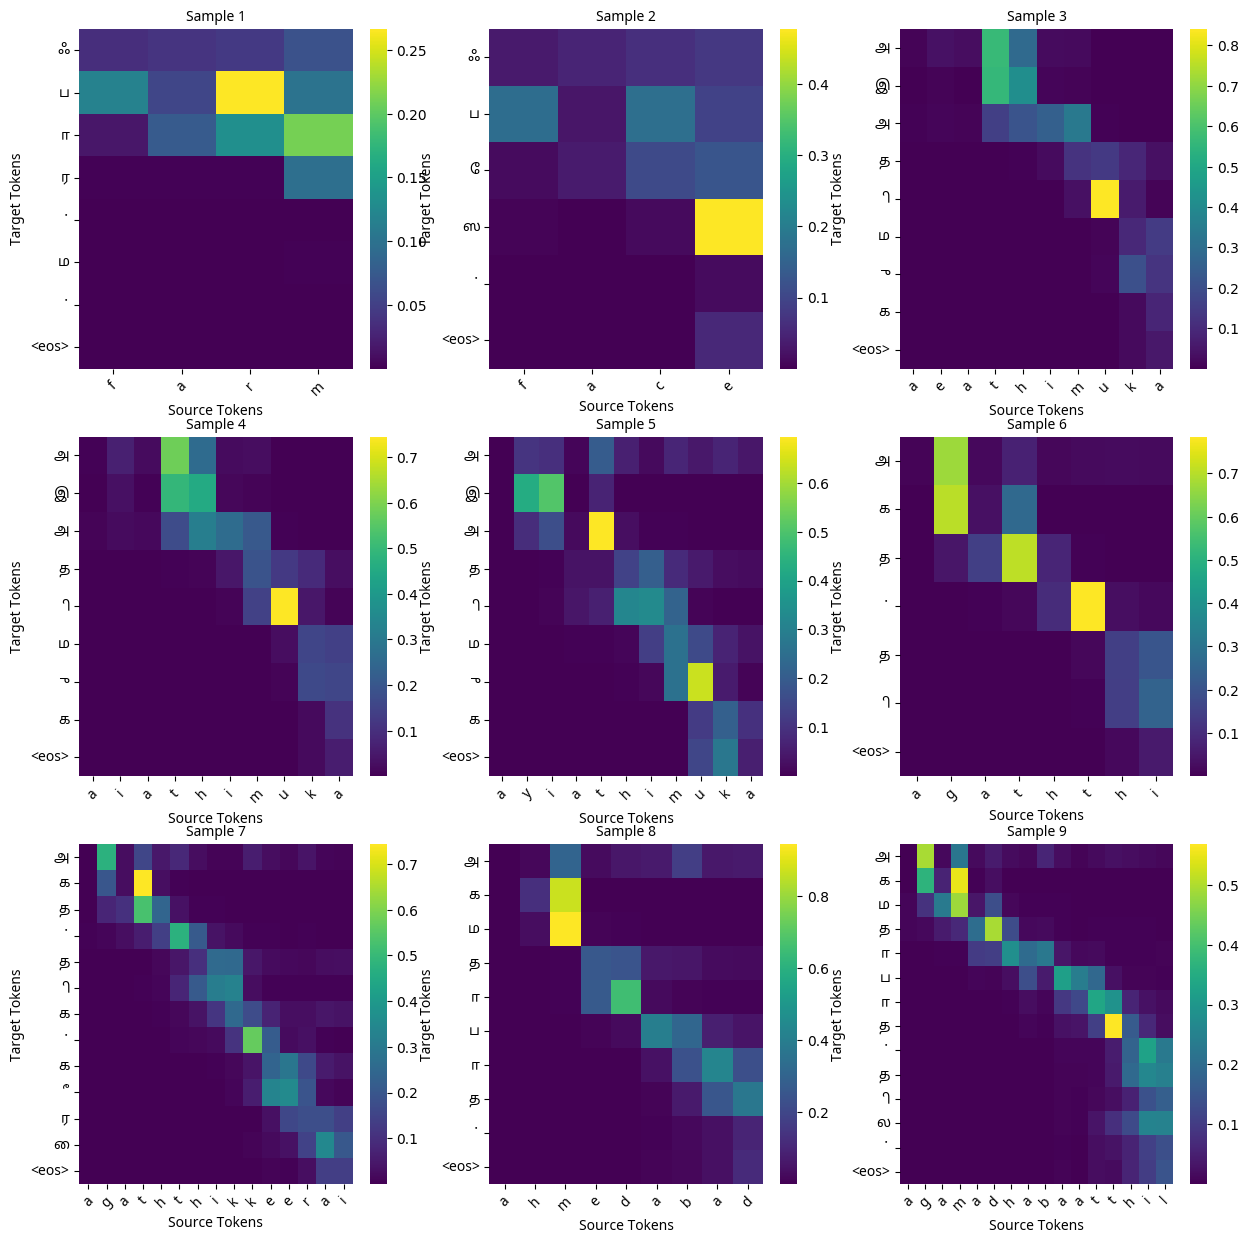

In [1]:
import torch
import torch.nn as nn
import os
import wandb
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Initialize wandb - will use WANDB_API_KEY environment variable if available
try:
    # Fix wandb login - only call once
    wandb.login(key="999fe4f321204bd8f10135f3e40de296c23050f9")
except:
    print("WandB login failed - results will not be logged. Set WANDB_API_KEY in your environment.")

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, bidirectional=False):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)

        self.directions = 2 if bidirectional else 1

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True,
                              dropout=dropout if num_layers > 1 else 0,
                              bidirectional=bidirectional)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers, batch_first=True,
                             dropout=dropout if num_layers > 1 else 0,
                             bidirectional=bidirectional)
        else:  # rnn
            self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers, batch_first=True,
                             dropout=dropout if num_layers > 1 else 0,
                             bidirectional=bidirectional)

        # Projection layer to reduce bidirectional output to the expected dimension
        if bidirectional:
            self.projection = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))

        if self.rnn_type == 'lstm':
            outputs, (hidden, cell) = self.rnn(embedded)

            # Process bidirectional states if needed
            if self.bidirectional:
                # Process hidden states
                hidden = hidden.view(self.num_layers, self.directions, -1, self.hidden_dim)
                # Concat forward and backward directions
                hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
                # Project to the correct dimension
                hidden = self.projection(hidden)

                # Process cell states
                cell = cell.view(self.num_layers, self.directions, -1, self.hidden_dim)
                cell = torch.cat([cell[:, 0], cell[:, 1]], dim=2)
                cell = self.projection(cell)

                # If outputs is bidirectional, we need to process it too
                batch_size = outputs.size(0)
                seq_len = outputs.size(1)
                # Reshape and project encoder outputs
                outputs = outputs.contiguous().view(batch_size, seq_len, self.hidden_dim * 2)
                outputs = self.projection(outputs)

                return outputs, (hidden, cell)
            return outputs, (hidden, cell)
        else:
            outputs, hidden = self.rnn(embedded)

            # Process bidirectional states if needed
            if self.bidirectional:
                hidden = hidden.view(self.num_layers, self.directions, -1, self.hidden_dim)
                hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
                hidden = self.projection(hidden)

                # Process outputs if bidirectional
                batch_size = outputs.size(0)
                seq_len = outputs.size(1)
                # Reshape and project encoder outputs
                outputs = outputs.contiguous().view(batch_size, seq_len, self.hidden_dim * 2)
                outputs = self.projection(outputs)

            return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, rnn_type, dropout=0.5, attention=False):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = nn.Dropout(dropout)
        self.attention = attention

        # Increase input size if using attention
        rnn_input_size = emb_dim + hidden_dim if attention else emb_dim

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(rnn_input_size, hidden_dim, num_layers, batch_first=True,
                              dropout=dropout if num_layers > 1 else 0)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(rnn_input_size, hidden_dim, num_layers, batch_first=True,
                             dropout=dropout if num_layers > 1 else 0)
        else:  # rnn
            self.rnn = nn.RNN(rnn_input_size, hidden_dim, num_layers, batch_first=True,
                             dropout=dropout if num_layers > 1 else 0)

        # Attention mechanism
        if attention:
            # Attention layers - simplified approach that works with any encoder output dimensionality
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_char, hidden, encoder_outputs=None):
        input_char = input_char.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input_char))  # [batch_size, 1, emb_dim]

        # Apply attention if enabled and encoder_outputs are provided
        if self.attention and encoder_outputs is not None:
            # Make sure we're extracting the hidden state correctly based on RNN type
            if self.rnn_type == 'lstm':
                query = hidden[0][-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
            else:
                query = hidden[-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]

            # Get dimensions
            batch_size = encoder_outputs.size(0)
            src_len = encoder_outputs.size(1)

            # Create energy by combining query with encoder outputs
            query = query.repeat(1, src_len, 1)  # [batch_size, src_len, hidden_dim]

            # Concatenate query with encoder outputs
            energy_input = torch.cat((query, encoder_outputs), dim=2)  # [batch_size, src_len, 2*hidden_dim]

            # Calculate attention scores
            energy = torch.tanh(self.attn(energy_input))  # [batch_size, src_len, hidden_dim]
            attention = self.v(energy).squeeze(2)  # [batch_size, src_len]

            # Apply softmax to get attention weights
            attention_weights = torch.softmax(attention, dim=1).unsqueeze(1)  # [batch_size, 1, src_len]

            # Create context vector by applying attention weights to encoder outputs
            context = torch.bmm(attention_weights, encoder_outputs)  # [batch_size, 1, hidden_dim]

            # Combine with embedding
            rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, emb_dim+hidden_dim]
        else:
            rnn_input = embedded

        # Forward pass through RNN
        if self.rnn_type == 'lstm':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
            hidden_state = (hidden, cell)
        else:
            output, hidden = self.rnn(rnn_input, hidden)
            hidden_state = hidden

        # Generate prediction
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]

        # Return attention_weights if available
        if self.attention and encoder_outputs is not None:
            return prediction, hidden_state, attention_weights.squeeze(1)  # [batch_size, src_len]
        else:
            return prediction, hidden_state, None


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, rnn_type, device, use_attention=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rnn_type = rnn_type
        self.device = device
        self.use_attention = use_attention

    def forward(self, src, trg, teacher_forcing_ratio=0.0):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # For collecting attention weights
        all_attention_weights = [] if self.use_attention else None

        # Encode the source sequence
        encoder_outputs, hidden = self._encode(src)

        # Use the first token as input to start decoding
        input_char = trg[:, 0]  # <sos> token

        for t in range(1, trg_len):
            # Generate output from decoder
            if self.use_attention:
                output, hidden, attn_weights  = self.decoder(input_char, hidden, encoder_outputs)
                all_attention_weights.append(attn_weights)  # <-- ADD THIS LINE
            else:
                output, hidden, _ = self.decoder(input_char, hidden)

            outputs[:, t] = output

            # Teacher forcing: use real target or predicted token
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_char = trg[:, t] if teacher_force else top1

        return outputs, all_attention_weights

    def _encode(self, src):
        # Get encoder outputs and final hidden state
        encoder_outputs, hidden = self.encoder(src)

        # Adjust hidden state dimensions if encoder and decoder have different layers
        encoder_layers = self.encoder.num_layers
        decoder_layers = self.decoder.num_layers

        if self.rnn_type == 'lstm':
            hidden_state, cell_state = hidden

            # If encoder has fewer layers than decoder, pad with zeros
            if encoder_layers < decoder_layers:
                padding = torch.zeros(
                    decoder_layers - encoder_layers,
                    hidden_state.size(1),
                    hidden_state.size(2)
                ).to(self.device)
                hidden_state = torch.cat([hidden_state, padding], dim=0)
                cell_state = torch.cat([cell_state, padding], dim=0)

            # If encoder has more layers than decoder, truncate
            elif encoder_layers > decoder_layers:
                hidden_state = hidden_state[:decoder_layers]
                cell_state = cell_state[:decoder_layers]

            # Make sure hidden dimensions match decoder's expected dimensions
            if hidden_state.size(2) != self.decoder.hidden_dim:
                # Project hidden state to the decoder's dimension using a linear projection
                batch_size = hidden_state.size(1)
                proj_hidden = torch.zeros(
                    hidden_state.size(0),
                    batch_size,
                    self.decoder.hidden_dim
                ).to(self.device)

                for layer in range(hidden_state.size(0)):
                    # Simple linear projection for each layer
                    proj_hidden[layer] = hidden_state[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]

                # Apply the same projection to cell state
                proj_cell = torch.zeros_like(proj_hidden)
                for layer in range(cell_state.size(0)):
                    proj_cell[layer] = cell_state[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]

                hidden = (proj_hidden, proj_cell)
            else:
                hidden = (hidden_state, cell_state)
        else:
            # For GRU and RNN
            # If encoder has fewer layers than decoder, pad with zeros
            if encoder_layers < decoder_layers:
                padding = torch.zeros(
                    decoder_layers - encoder_layers,
                    hidden.size(1),
                    hidden.size(2)
                ).to(self.device)
                hidden = torch.cat([hidden, padding], dim=0)
            # If encoder has more layers than decoder, truncate
            elif encoder_layers > decoder_layers:
                hidden = hidden[:decoder_layers]

            # Make sure hidden dimensions match decoder's expected dimensions
            if hidden.size(2) != self.decoder.hidden_dim:
                # Project hidden state to the decoder's dimension
                batch_size = hidden.size(1)
                proj_hidden = torch.zeros(
                    hidden.size(0),
                    batch_size,
                    self.decoder.hidden_dim
                ).to(self.device)

                for layer in range(hidden.size(0)):
                    # Simple linear projection for each layer
                    proj_hidden[layer] = hidden[layer].clone().view(batch_size, -1)[:, :self.decoder.hidden_dim]

                hidden = proj_hidden

        return encoder_outputs, hidden

# Character-level vocabulary builder
def build_vocab(tokens):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    for token in tokens:
        for char in token:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

def encode_sequence(seq, vocab):
    return [vocab.get(char, vocab['<unk>']) for char in seq]

class DakshinaDataset(Dataset):
    def __init__(self, data_path, latin_vocab=None, devanagari_vocab=None):
        self.latin_words = []
        self.devanagari_words = []

        # Group all transliterations by Devanagari word
        candidates = defaultdict(list)

        with open(data_path, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 3:
                    continue
                native, latin, rel = parts[0], parts[1], int(parts[2])
                candidates[native].append((latin, rel))

        # Keep only the transliteration(s) with highest score for each native word
        for native, translits in candidates.items():
            max_rel = max(rel for _, rel in translits)
            for latin, rel in translits:
                if rel == max_rel:
                    self.latin_words.append(latin)
                    self.devanagari_words.append(native)

        print(f"Dataset from {data_path}: {len(self.latin_words)} pairs.")

        self.latin_vocab = latin_vocab or build_vocab(self.latin_words)
        self.devanagari_vocab = devanagari_vocab or build_vocab(self.devanagari_words)

    def __len__(self):
        return len(self.latin_words)

    def __getitem__(self, idx):
        src_seq = encode_sequence(self.latin_words[idx], self.latin_vocab)
        trg_seq = encode_sequence(self.devanagari_words[idx], self.devanagari_vocab)
        # add <sos> and <eos> tokens for target sequences
        trg_seq = [self.devanagari_vocab['<sos>']] + trg_seq + [self.devanagari_vocab['<eos>']]
        return src_seq, trg_seq

def collate_fn(batch):
    # batch is a list of tuples (src_seq, trg_seq)
    src_seqs, trg_seqs = zip(*batch)

    # find max lengths
    max_src_len = max(len(seq) for seq in src_seqs)
    max_trg_len = max(len(seq) for seq in trg_seqs)

    # pad sequences
    src_padded = [seq + [0]*(max_src_len - len(seq)) for seq in src_seqs]
    trg_padded = [seq + [0]*(max_trg_len - len(seq)) for seq in trg_seqs]

    # convert to tensors
    src_tensor = torch.tensor(src_padded, dtype=torch.long)
    trg_tensor = torch.tensor(trg_padded, dtype=torch.long)

    return src_tensor, trg_tensor

def compute_word_accuracy(preds, trg, pad_idx, sos_idx=1, eos_idx=2):
    """
    Compute word-level accuracy: a word is correct only if all tokens match (excluding pad, sos, eos).
    preds, trg: [batch_size, seq_len]
    """
    batch_size = preds.size(0)
    correct = 0

    for i in range(batch_size):
        # Get sequence for this example (exclude pad, sos, eos tokens)
        pred_seq = [idx for idx in preds[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
        trg_seq = [idx for idx in trg[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]

        # Compare full sequences (exact match)
        if pred_seq == trg_seq:
            correct += 1

    return correct, batch_size

def beam_search(model, src_seq, src_vocab, tgt_vocab, beam_width=3, max_len=20):
    model.eval()
    index_to_char = {v: k for k, v in tgt_vocab.items()}
    device = model.device

    # Prepare input
    src_indices = encode_sequence(src_seq, src_vocab)
    src_tensor = torch.tensor([src_indices], dtype=torch.long).to(device)

    # Get encoder outputs and hidden state
    encoder_outputs, hidden = model._encode(src_tensor)

    # Start with start-of-sequence token
    beams = [([tgt_vocab['<sos>']], 0.0, hidden)]

    for _ in range(max_len):
        new_beams = []
        for seq, score, hidden in beams:
            last_token = torch.tensor([seq[-1]], dtype=torch.long).to(device)

            # Use attention if model has it
            if model.use_attention:
                output, new_hidden, _ = model.decoder(last_token, hidden, encoder_outputs)
            else:
                output, new_hidden = model.decoder(last_token, hidden)

            log_probs = torch.log_softmax(output, dim=-1)
            topk = torch.topk(log_probs, beam_width)

            for prob, idx in zip(topk.values[0], topk.indices[0]):
                new_seq = seq + [idx.item()]
                new_score = score + prob.item()
                new_beams.append((new_seq, new_score, new_hidden))

        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        # Stop if all beams end with EOS
        if all(seq[-1] == tgt_vocab['<eos>'] for seq, _, _ in beams):
            break

    # Pick the best beam
    best_seq = beams[0][0]
    # Remove special tokens for output
    decoded = [index_to_char[i] for i in best_seq if i not in {tgt_vocab['<sos>'], tgt_vocab['<eos>'], tgt_vocab['<pad>']}]
    return ''.join(decoded)

def train(model, dataloader, optimizer, criterion, clip=1, teacher_forcing_ratio=0.0):
    model.train()
    epoch_loss = 0
    total_words = 0
    correct_words = 0

    pad_idx = 0  # Pad index in vocabulary
    sos_idx = 1  # Start of sequence index
    eos_idx = 2  # End of sequence index

    for src, trg in dataloader:
        src, trg = src.to(model.device), trg.to(model.device)
        optimizer.zero_grad()

        # Generate sequence
        output, _ = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)
        output_dim = output.shape[-1]

        # Ignore first token (<sos>) in loss calculation
        output = output[:, 1:].contiguous().view(-1, output_dim)
        trg_flat = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg_flat)
        loss.backward()

        # Use gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate word accuracy
        pred_tokens = output.argmax(1).view(trg[:, 1:].shape)  # [batch_size, trg_len-1]
        trg_trimmed = trg[:, 1:]                             # [batch_size, trg_len-1]

        correct, total = compute_word_accuracy(pred_tokens, trg_trimmed, pad_idx, sos_idx, eos_idx)
        correct_words += correct
        total_words += total

    avg_loss = epoch_loss / len(dataloader)
    word_acc = correct_words / total_words if total_words > 0 else 0

    return avg_loss, word_acc * 100

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    total_words = 0
    correct_words = 0

    pad_idx = 0  # Pad index in vocabulary
    sos_idx = 1  # Start of sequence index
    eos_idx = 2  # End of sequence index

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)

            # Generate full sequence with no teacher forcing
            output, _  = model(src, trg, teacher_forcing_ratio=0.0)
            # Visualize for the first example in batch
            # attn = torch.stack([aw[0] for aw in attention_weights]).cpu().numpy()
            output_dim = output.shape[-1]

            # Ignore first token (<sos>) in loss calculation
            output = output[:, 1:].contiguous().view(-1, output_dim)
            trg_flat = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg_flat)
            epoch_loss += loss.item()

            # Calculate word accuracy
            pred_tokens = output.argmax(1).view(trg[:, 1:].shape)
            trg_trimmed = trg[:, 1:]

            correct, total = compute_word_accuracy(pred_tokens, trg_trimmed, pad_idx, sos_idx, eos_idx)
            correct_words += correct
            total_words += total

    avg_loss = epoch_loss / len(dataloader)
    word_acc = correct_words / total_words if total_words > 0 else 0

    return avg_loss, word_acc * 100

def predict_examples(model, dataloader, latin_index_to_token, devanagari_index_to_token, n=5):
    """Show a few examples of model predictions vs actual targets"""
    model.eval()
    pad_idx = 0
    sos_idx = 1  # Start of sequence
    eos_idx = 2  # End of sequence
    count = 0
    results = []

    print("\nPrediction Examples:")
    print("-" * 60)

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)
            output, _ = model(src, trg, teacher_forcing_ratio=0.0)
            # print(len(output))
            pred_tokens = output.argmax(-1)  # [batch_size, seq_len]

            for i in range(min(src.size(0), n - count)):
                # Decode input
                input_indices = [idx for idx in src[i].tolist() if idx != pad_idx]
                input_tokens = [latin_index_to_token.get(idx, '<unk>') for idx in input_indices]
                input_text = "".join(input_tokens)

                # Decode target
                target_indices = [idx for idx in trg[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
                target_tokens = [devanagari_index_to_token.get(idx, '<unk>') for idx in target_indices]
                target_text = "".join(target_tokens)

                # Decode prediction
                pred_indices = [idx for idx in pred_tokens[i].tolist() if idx not in [pad_idx, sos_idx, eos_idx]]
                pred_tokens_text = [devanagari_index_to_token.get(idx, '<unk>') for idx in pred_indices]
                pred_text = "".join(pred_tokens_text)

                result = {
                    "input": input_text,
                    "target": target_text,
                    "prediction": pred_text,
                    "correct": pred_text == target_text
                }
                results.append(result)

                print(f"Input:     {input_text}")
                print(f"Target:    {target_text}")
                print(f"Predicted: {pred_text}")
                print("-" * 60)

                count += 1
                if count >= n:
                    break
            if count >= n:
                break

    return results
    
import matplotlib.pyplot as plt
import seaborn as sns

# Define sweep configuration with improved parameters
def get_sweep_config():
    sweep_config = {
        'method': 'random',
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'},
            'parameters': {
            'embed_dim': {'values': [128,256,384]},
            'hidden_dim': {'values': [256,384,512]},
            'rnn_type': {'values': ['lstm','gru']}, 
            'encoder_layers': {'values': [3,2]},
            'decoder_layers': {'values': [3,2]},
            'dropout': {'values': [0.2,0.3]},
            'learning_rate': {'values': [0.001,1e-4]},
            'batch_size': {'values': [128,256]},
            'epochs': {'values': [5,10]},
            'beam_size': {'values': [3,5]},
            'use_attention': {'values': [True]},
            'bidirectional': {'values': [True]},
            'teacher_forcing_ratio': {'values': [0.0, 0.3]},
            'weight_decay': {'values': [1e-5, 1e-6]}
        }
    }
    return sweep_config

# Main training function for sweep runs
def train_sweep():
    # Initialize wandb with sweep configuration
    run = wandb.init(project="transliteration-model")

    # Access hyperparameters from wandb.config
    config = run.config

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define data paths (adjust for Kaggle environment)
    data_dir = '/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/'
    train_path = os.path.join(data_dir, 'ta.translit.sampled.train.tsv')
    dev_path = os.path.join(data_dir, 'ta.translit.sampled.dev.tsv')
    test_path = os.path.join(data_dir, 'ta.translit.sampled.test.tsv')

    # Check if files exist
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Could not find training data at {train_path}. Please check the path.")

    # Load datasets
    print("Loading training dataset...")
    train_dataset = DakshinaDataset(train_path)
    latin_vocab = train_dataset.latin_vocab
    devanagari_vocab = train_dataset.devanagari_vocab

    print("Loading validation dataset...")
    val_dataset = DakshinaDataset(
        dev_path,
        latin_vocab=latin_vocab,
        devanagari_vocab=devanagari_vocab
    )

    print("Loading test dataset...")
    test_dataset = DakshinaDataset(
        test_path,
        latin_vocab=latin_vocab,
        devanagari_vocab=devanagari_vocab
    )

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Get vocabulary information
    latin_vocab_size = len(latin_vocab)
    devanagari_vocab_size = len(devanagari_vocab)
    pad_idx = devanagari_vocab['<pad>']

    # Log vocabulary sizes
    wandb.log({"latin_vocab_size": latin_vocab_size, "devanagari_vocab_size": devanagari_vocab_size})

    # Generate a model name based on hyperparameters
    model_name = f"{config.rnn_type}_ed{config.embed_dim}_hid{config.hidden_dim}_enc{config.encoder_layers}_dec{config.decoder_layers}_attn{config.use_attention}_drop{config.dropout}"
    wandb.run.name = model_name

    # Create model architecture
    encoder = Encoder(
        input_dim=latin_vocab_size,
        emb_dim=config.embed_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.encoder_layers,
        rnn_type=config.rnn_type,
        dropout=config.dropout,
        bidirectional=config.bidirectional
    )

    decoder = Decoder(
        output_dim=devanagari_vocab_size,
        emb_dim=config.embed_dim,
        hidden_dim=config.hidden_dim,
        num_layers=config.decoder_layers,
        rnn_type=config.rnn_type,
        dropout=config.dropout,
        attention=config.use_attention
    )

    model = Seq2Seq(
        encoder,
        decoder,
        rnn_type=config.rnn_type,
        device=device,
        use_attention=config.use_attention
    ).to(device)

    # Count and log the number of model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    wandb.log({
        "total_parameters": total_params,
        "trainable_parameters": trainable_params
    })
    print(f"Model: {model_name}")
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    # Setup optimizer and loss function with weight decay for regularization
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=2,
        verbose=True
    )

    criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_acc = 0
    patience = 5  # Increased patience
    patience_counter = 0

    # Save directory for models
    model_dir = '/kaggle/working/models'
    os.makedirs(model_dir, exist_ok=True)

    # Track metrics for each epoch
    for epoch in range(config.epochs):
        print(f"\nEpoch {epoch+1}/{config.epochs}")

        # Train
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, clip=1.0,
                                      teacher_forcing_ratio=config.teacher_forcing_ratio)
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Validate
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        # Save best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0

            # Save the best model
            best_model_path = os.path.join(model_dir, f"{model_name}_best.pt")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with val accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    # Load the best model for testing
    best_model_path = os.path.join(model_dir, f"{model_name}_best.pt")
    try:
        model.load_state_dict(torch.load(best_model_path))
        print("Loaded best model for testing")
    except:
        print("Using current model for testing (best model not found)")

    # Final evaluation on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"\nTest Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

    # Log final test metrics
    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc
    })

    # Create index-to-token dictionaries for prediction display
    latin_index_to_token = {idx: token for token, idx in latin_vocab.items()}
    devanagari_index_to_token = {idx: token for token, idx in devanagari_vocab.items()}

    # Generate prediction examples for visualization
    example_results = predict_examples(
        model,
        test_loader,
        latin_index_to_token,
        devanagari_index_to_token,
        n=5
    )

    # Log the examples as a table in wandb
    example_table = wandb.Table(
        columns=["Input", "Target", "Prediction", "Correct"]
    )
    for result in example_results:
        example_table.add_data(
            result["input"],
            result["target"],
            result["prediction"],
            result["correct"]
        )
    wandb.log({"prediction_examples": example_table})

    # Test beam search if enabled
    if config.beam_size > 1:
        print(f"\nTesting beam search with beam width {config.beam_size}...")
        beam_correct = 0
        beam_total = 0

        for src, trg in test_loader:
            src = src.to(device)
            trg = trg.to(device)
            for i in range(min(5, src.size(0))):  # Test beam search on a few examples
                # Get input sequence
                src_seq = [latin_index_to_token[idx] for idx in src[i].tolist() if idx != pad_idx]
                src_text = ''.join(src_seq)

                # Get target sequence
                trg_indices = [idx for idx in trg[i].tolist() if idx not in [pad_idx, 1]]  # Remove <pad> and <sos>
                trg_text = ''.join([devanagari_index_to_token.get(idx, '<unk>') for idx in trg_indices])

                # Run beam search
                beam_pred = beam_search(
                    model,
                    src_text,
                    latin_vocab,
                    devanagari_vocab,
                    beam_width=config.beam_size,
                    max_len=30
                )

                beam_correct += 1 if beam_pred == trg_text else 0
                beam_total += 1

                # print(f"Input: {src_text}")
                # print(f"Target: {trg_text}")
                # print(f"Beam Pred: {beam_pred}")
                # print("-" * 60)

        beam_acc = beam_correct / beam_total * 100 if beam_total > 0 else 0
        print(f"Beam search accuracy: {beam_acc:.2f}%")
        wandb.log({"beam_search_accuracy": beam_acc})
        
    plot_attention_grid(model, test_loader, idx_to_src_token=latin_index_to_token, idx_to_tgt_token=devanagari_index_to_token)

    return model, latin_vocab, devanagari_vocab


import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

def plot_attention_grid(model, dataloader, idx_to_src_token=None, idx_to_tgt_token=None, num_samples=9):
    model.eval()
    
    # Load Tamil font (update the path as per your font location)
    tamil_font_path = "/kaggle/input/notations-tamil/static/NotoSansTamil-Regular.ttf"  # Put this font file in the working dir or give full path
    tamil_font = font_manager.FontProperties(fname=tamil_font_path)

    samples_plotted = 0
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(model.device), trg.to(model.device)

            # Forward pass with no teacher forcing to get attention
            output, attention_weights = model(src, trg, teacher_forcing_ratio=0.0)

            if not attention_weights:
                print("No attention weights returned by the model.")
                return
            
            # Shape: [tgt_len-1, batch_size, src_len]
            attn_tensor = torch.stack(attention_weights)

            batch_size = src.size(0)

            for i in range(batch_size):
                if samples_plotted >= num_samples:
                    break

                # Tokens
                if idx_to_src_token and idx_to_tgt_token:
                    src_tokens = [idx_to_src_token[idx.item()] for idx in src[i]]
                    tgt_tokens = [idx_to_tgt_token[idx.item()] for idx in trg[i][1:]]  # skip <sos>
                else:
                    src_tokens = None
                    tgt_tokens = None

                # Remove <pad> tokens and track lengths
                src_tokens_clean = [tok for tok in src_tokens if tok != "<pad>"]
                tgt_tokens_clean = [tok for tok in tgt_tokens if tok != "<pad>"]
                src_trim_len = len(src_tokens_clean)
                tgt_trim_len = len(tgt_tokens_clean)

                # Trim attention to match cleaned tokens
                attn_for_sample = attn_tensor[:, i, :].cpu().numpy()  # [tgt_len-1, src_len]
                attn_for_sample = attn_for_sample[:tgt_trim_len, :src_trim_len]

                # Plot
                ax = axes[samples_plotted]
                sns.heatmap(attn_for_sample, cmap="viridis",
                            xticklabels=src_tokens_clean,
                            yticklabels=tgt_tokens_clean,
                            ax=ax)
                ax.set_xlabel("Source Tokens", fontproperties=tamil_font)
                ax.set_ylabel("Target Tokens", fontproperties=tamil_font)
                ax.set_title(f"Sample {samples_plotted + 1}", fontproperties=tamil_font)
                ax.tick_params(axis='x', rotation=45)
                ax.tick_params(axis='y', rotation=0)

                # Apply Tamil font to tick labels
                for label in ax.get_xticklabels() + ax.get_yticklabels():
                    label.set_fontproperties(tamil_font)

                samples_plotted += 1

            if samples_plotted >= num_samples:
                break
    plt.savefig("heatmap.png", dpi = 300)
    # wandb.log("heatmap.png")
    wandb.log({"attention_heatmap": wandb.Image("heatmap.png")})
    plt.tight_layout()
    plt.show()


# Entry point - runs a wandb sweep
def run_wandb_sweep():
    sweep_config = get_sweep_config()
    sweep_id = wandb.sweep(sweep_config, project="transliteration-model-tam1")
    wandb.agent(sweep_id, train_sweep, count=1)


# Main execution block for Kaggle
if __name__ == "__main__":
    # Run the wandb sweep
    run_wandb_sweep()